# Crypto Project

## Import Libraries

In [1]:
%load_ext autoreload
%reload_ext autoreload

# Import all the necessary modules

import os
import re
import pathlib
import json
import sqlalchemy as db
import requests
import yfinance as yf
from pycoingecko import CoinGeckoAPI

from datetime import datetime, date

import numpy as np
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats

import matplotlib.pyplot as plt
import seaborn as sns
import mplfinance as mpf
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import seasonal_decompose

import plotly.offline as pyo
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

pyo.init_notebook_mode(connected=True)
cg = CoinGeckoAPI()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

project_dir = pathlib.Path().absolute()
workdir = project_dir.parent


In [2]:
# Import external functions

from cr_data_loader import jprint, get_json_data, get_quandl_data, get_yfinance_data, get_datareader_data, get_poloniex_data, get_eia_data
from cr_data_manipulate import check_items, value_mapper, df_date_to_col, df_preprocess, load_to_sql, create_date_table, df_save_to_csv

<a id='data_collection'></a>
## <font color='darkblue'>__Data Collection__</font>

#### <font color='darkblue'>__Collect Market & Exchange data__</font>

In [3]:
# Market (Asset) Data from Coingecko.com

markets_list = cg.get_coins_markets(vs_currency='usd')
market_names = []
for item in markets_list:
    market_names.append(item['name'])
df_cg_markets = pd.DataFrame.from_dict(markets_list)
df_cg_markets.columns = df_cg_markets.columns.str.title()
df_cg_markets.head()

,Id,Symbol,Name,Image,Current_Price,Market_Cap,Market_Cap_Rank,Fully_Diluted_Valuation,Total_Volume,High_24H,...,Total_Supply,Max_Supply,Ath,Ath_Change_Percentage,Ath_Date,Atl,Atl_Change_Percentage,Atl_Date,Roi,Last_Updated
0,bitcoin,btc,Bitcoin,https://assets.coingecko.com/coins/images/1/la...,62608.00,1169690383971,1,1.314773e+12,78859732845,64805.00,...,2.100000e+07,21000000.0,64805.00,-3.28540,2021-04-14T11:54:46.763Z,67.810000,9.232966e+04,2013-07-06T00:00:00.000Z,None,2021-04-14T21:29:06.252Z
1,ethereum,eth,Ethereum,https://assets.coingecko.com/coins/images/279/...,2392.52,276264733895,2,NaN,41369975572,2399.57,...,NaN,NaN,2399.57,-0.25556,2021-04-14T11:54:12.227Z,0.432979,5.526851e+05,2015-10-20T00:00:00.000Z,"{'times': 50.10750290675354, 'currency': 'btc'...",2021-04-14T21:28:28.364Z
2,binancecoin,bnb,Binance Coin,https://assets.coingecko.com/coins/images/825/...,541.42,83738709995,3,9.240879e+10,8343663403,587.90,...,1.705337e+08,170533651.9,610.06,-11.17526,2021-04-12T09:32:32.635Z,0.039818,1.360803e+06,2017-10-19T00:00:00.000Z,None,2021-04-14T21:29:29.258Z
3,ripple,xrp,XRP,https://assets.coingecko.com/coins/images/44/l...,1.77,81228472829,4,NaN,24033347806,1.95,...,1.000000e+11,NaN,3.40,-48.08480,2018-01-07T00:00:00.000Z,0.002686,6.558043e+04,2014-05-22T00:00:00.000Z,None,2021-04-14T21:30:20.009Z
4,cardano,ada,Cardano,https://assets.coingecko.com/coins/images/975/...,1.45,46330121657,5,NaN,8758071791,1.55,...,4.500000e+10,NaN,1.55,-6.53337,2021-04-14T08:44:43.794Z,0.019253,7.411950e+03,2020-03-13T02:22:55.044Z,None,2021-04-14T21:30:06.024Z


In [4]:
# Exchange Data from Coingecko.com

exchanges_list = cg.get_exchanges_list()
exchange_names = []
for item in exchanges_list:
    exchange_names.append(item['name'])
df_cg_exchanges = pd.DataFrame.from_dict(exchanges_list)
df_cg_exchanges.columns = df_cg_exchanges.columns.str.title() 
df_cg_exchanges.head()

,Id,Name,Year_Established,Country,Description,Url,Image,Has_Trading_Incentive,Trust_Score,Trust_Score_Rank,Trade_Volume_24H_Btc,Trade_Volume_24H_Btc_Normalized
0,binance,Binance,2017.0,Cayman Islands,,https://www.binance.com/,https://assets.coingecko.com/markets/images/52...,False,10,1,866624.061063,866624.061063
1,gdax,Coinbase Pro,2012.0,United States,,https://www.coinbase.com,https://assets.coingecko.com/markets/images/23...,False,10,2,78940.258843,78940.258843
2,kraken,Kraken,2011.0,United States,,https://r.kraken.com/Q1m9x,https://assets.coingecko.com/markets/images/29...,False,10,3,51233.705483,51233.705483
3,bitfinex,Bitfinex,2014.0,British Virgin Islands,,https://www.bitfinex.com,https://assets.coingecko.com/markets/images/4/...,False,10,4,35076.073906,35076.073906
4,binance_us,Binance US,2019.0,United States,,https://www.binance.us/en,https://assets.coingecko.com/markets/images/46...,False,10,5,21675.237738,21675.237738


In [5]:
print(f"No. of Assests:   {len(market_names)}\n" \
      f"No. of Exchanges: {len(exchange_names)}")

No. of Assests:   100
No. of Exchanges: 100


In [6]:
print(set(df_cg_markets['Symbol'].str.upper()))

{'OMI', 'XSUSHI', 'UMA', 'CDAI', 'STX', 'WAVES', 'ETH', 'SC', 'XEM', 'XRP', 'OMG', 'KLAY', 'NEAR', 'HOT', 'CRO', 'CHZ', 'BTC', 'UNI', 'CAKE', 'THETA', 'SOL', 'GRT', 'LUNA', 'COMP', 'MIOTA', 'HBTC', 'ADA', 'ZIL', 'WIN', 'OKB', 'KCS', 'USDC', 'ICX', 'XDC', 'FTT', 'MATIC', 'BNB', 'DASH', 'HT', 'ZRX', 'FIL', 'ZEC', 'CETH', 'CUSDC', 'DGB', 'UST', 'DCR', 'BCH', 'BSV', 'MKR', 'DOGE', 'BAT', 'HNT', 'BNT', 'NEXO', 'RSR', 'BTT', 'SUSHI', 'WBTC', 'VET', 'ATOM', 'LEO', 'FEI', 'RUNE', 'XLM', 'HBAR', 'MANA', 'ONE', 'AVAX', 'FTM', 'LINK', 'BUSD', 'RVN', 'LTC', 'ETC', 'NEO', 'BTG', 'AMP', 'VGX', 'ONT', 'DOT', 'FLOW', 'SNX', 'ANKR', 'ALGO', 'DAI', 'ENJ', 'CEL', 'USDT', 'XMR', 'XTZ', 'EOS', 'TRX', 'AR', 'EGLD', 'KSM', 'YFI', 'IOST', 'AAVE', 'QTUM'}


In [7]:
print(set(df_cg_exchanges['Id'].str.upper()))

{'BTCMARKETS', 'EMIREX', 'PROBIT', 'BTCTURK', 'DIGIFINEX', 'GMO_JAPAN', 'XT', 'COINEAL', 'WAZIRX', 'OMGFIN', 'WHITEBIT', 'BITRUE', 'COINSBIT', 'BITHUMB', 'OKCOIN', 'BW', 'BIGONE', 'COINTIGER', 'CRYPTO_COM', 'BITKUB', 'GATE', 'COINONE', 'THODEX', 'BINANCE_US', 'NOMINEX', 'HITBTC', 'INDODAX', 'UPBIT', 'BITPANDA', 'BITGET', 'SUSHISWAP', 'MERCADO_BITCOIN', 'AEX', 'KRAKEN', 'KORBIT', 'BITCOIN_COM', 'VCC', 'COINHE', 'BITFINEX', 'ALTERDICE', 'LUNO', 'BINANCE', 'PARIBU', 'BITSO', 'HUOBI', 'HOTBIT', 'BITBANK', 'P2PB2B', 'LATOKEN', 'BIBOX', 'CHANGELLY', 'KUNA', 'NARKASA', 'BITTREX', 'GOPAX', 'BIDESK', 'CRYPTOLOGY', 'CBX', 'BITMART', 'NICE_HASH', 'OCEANEX', 'POLONIEX', 'LBANK', 'PHEMEX', 'ATOMARS', 'HOO', 'GDAX', 'BITFLYER', 'BITOFFER', 'BKEX', 'FTX_SPOT', 'ZB', 'MXC', 'UNISWAP', 'GEMINI', 'ZAIF', 'FTX_US', 'EXMO', 'COINCHECK', 'BTC_ALPHA', 'ETOROX', 'EXMARKETS', 'KUCOIN', 'BLOCKCHAIN_COM', 'MAX_MAICOIN', 'BIKI', 'QUOINE', 'BVNEX', 'DEXTRADE', 'INDEPENDENT_RESERVE', 'BITMAX', 'CEX', 'BITSTAMP', '

#### <font color='darkblue'>__Collect Bitcoin Data from different exchanges from Quandl__</font>

In [8]:
# Pull the Bitcoin Data from Quandl

from quandl.errors.quandl_error import NotFoundError

exchanges = df_cg_exchanges['Id'].str.upper()

df_run_all = []
    
for exchange in exchanges:
    exchange_code = f"BCHARTS/{exchange}USD"
   
    try:
        df = get_quandl_data(exchange_code)
        df['Exchange'] = exchange
        df_run_all.append(df)
        
    except NotFoundError as e:
        continue

df_quandl_btc_data = pd.concat(df_run_all)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-KRAKENUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFINEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITSTAMPUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-CEXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-BITFLYERUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-CBXUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-OKCOINUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-ITBITUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-HITBTCUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHARTS-P2PB2BUSD.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\B

In [9]:
# Rename the columns and sort the data
df_quandl_btc_data.rename(columns={'Volume (BTC)': 'Volume_BTC', 'Volume (Currency)': 'Volume_USD'}, inplace=True)
df_quandl_btc_data.sort_index(inplace=True)
df_quandl_btc_data.tail()

,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted Price,Exchange
2021-04-12,59916.80,61157.20,59484.80,59868.70,112.799534,6.788434e+06,60181.398728,CEX
2021-04-12,59972.26,61234.56,59361.11,59831.66,3707.436455,2.230737e+08,60169.263163,BITSTAMP
2021-04-13,59860.80,63647.20,59855.70,63228.80,196.629918,1.225174e+07,62308.619925,CEX
2021-04-13,59823.70,63882.50,59781.20,63273.90,6033.352095,3.762001e+08,62353.412081,KRAKEN
2021-04-13,59814.87,63769.00,59780.00,63315.59,5617.564271,3.489718e+08,62121.551005,BITSTAMP


#### <font color='darkblue'>__Collect Bitcoin Data from Poloniex__</font>

In [10]:
# Pull the Bitcoin Data from Poloniex, rename columns and sort
df_poloniex_btc_data = get_poloniex_data("USDT_BTC")
df_poloniex_btc_data.columns= df_poloniex_btc_data.columns.str.title()
df_poloniex_btc_data = df_poloniex_btc_data.rename(columns={'Volume': 'Volume_USD', 'Quotevolume': 'Volume_BTC',  
                                                     'Weightedaverage': 'Weighted Price'})

df_poloniex_btc_data['Exchange'] = 'POLONIEX'
column_names_btc=['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_USD', 'Weighted Price', 'Exchange']
df_poloniex_btc_data = df_poloniex_btc_data.reindex(columns=column_names_btc)
df_poloniex_btc_data.sort_index(inplace=True)
df_poloniex_btc_data.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\USDT_BTC.json from cache


,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted Price,Exchange
date,,,,,,,,
2021-04-10,58128.000000,61246.067767,57885.910800,59780.845701,1053.898684,6.330361e+07,60066.122555,POLONIEX
2021-04-11,59779.092332,60666.660000,59264.294109,60010.441365,507.439283,3.034617e+07,59802.556829,POLONIEX
2021-04-12,60010.441355,61227.566568,59350.282101,59849.876892,841.049495,5.060097e+07,60164.079978,POLONIEX
2021-04-13,59847.888448,63696.013872,59813.000000,63562.975202,1753.887293,1.087544e+08,62007.654271,POLONIEX
2021-04-14,63573.512081,64970.000000,61347.842075,61705.594089,1493.201851,9.490505e+07,63558.081850,POLONIEX


#### <font color='darkblue'>__Append Poloniex Data to have the consoildated BTC Dataset__</font>

In [11]:
# Append the Poloniex Data to Quandl Dataset, in order to have the consolidated Data
df_btc_data = df_quandl_btc_data.append(df_poloniex_btc_data)
df_btc_data.sort_values(by=['Exchange'])
df_btc_data['Market'] = "BTC"
df_btc_data = df_btc_data.sort_index()
df_btc_data.tail()

,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted Price,Exchange,Market
2021-04-13,59847.888448,63696.013872,59813.000000,63562.975202,1753.887293,1.087544e+08,62007.654271,POLONIEX,BTC
2021-04-13,59823.700000,63882.500000,59781.200000,63273.900000,6033.352095,3.762001e+08,62353.412081,KRAKEN,BTC
2021-04-13,59814.870000,63769.000000,59780.000000,63315.590000,5617.564271,3.489718e+08,62121.551005,BITSTAMP,BTC
2021-04-13,59860.800000,63647.200000,59855.700000,63228.800000,196.629918,1.225174e+07,62308.619925,CEX,BTC
2021-04-14,63573.512081,64970.000000,61347.842075,61705.594089,1493.201851,9.490505e+07,63558.081850,POLONIEX,BTC


## <a id='data_ingestion'></a>
## <font color='darkblue'>__Data Ingestion__</font>

#### <font color='darkblue'>__Collect Altcoin data from Poloniex__</font>

In [12]:
# Pull the Altcoin Data from Poloniex

altcoins = df_cg_markets['Symbol'].str.upper()
df_run_altcoin_new = []

for altcoin in altcoins:
    coinpair = f"BTC_{altcoin}"
    try:
        df = get_poloniex_data(coinpair)
        df['Market'] = altcoin
        df_run_altcoin_new.append(df)
                
    except ValueError as e:
        continue

df_altcoin_poloniex = pd.concat(df_run_altcoin_new)

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ETH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_XRP.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOT.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_LINK.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_BCH.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_DOGE.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_FIL.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_TRX.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_WBTC.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_EOS.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BTC_ATOM.json

In [13]:
# Rename the columns and sort the Data
df_altcoin_poloniex_data = df_altcoin_poloniex.sort_index()
df_altcoin_poloniex_data.columns = df_altcoin_poloniex_data.columns.str.title()
df_altcoin_poloniex_data = df_altcoin_poloniex_data.rename(columns={'Volume': 'Volume_BTC', 'Quotevolume': 'Volume_Market',  
                                                     'Weightedaverage': 'Weighted Price'})

df_altcoin_poloniex_data['Exchange'] = 'POLONIEX'
column_names_altcoin=['Open', 'High', 'Low', 'Close', 'Volume_BTC', 'Volume_Market', 'Weighted Price', 'Exchange', 'Market']
df_altcoin_poloniex_data = df_altcoin_poloniex_data.reindex(columns=column_names_altcoin)

df_altcoin_poloniex_data.tail()

,Open,High,Low,Close,Volume_BTC,Volume_Market,Weighted Price,Exchange,Market
date,,,,,,,,,
2021-04-14,0.000036,0.000037,0.000033,0.000034,0.357964,1.046320e+04,0.000034,POLONIEX,ZRX
2021-04-14,0.000378,0.000402,0.000359,0.000386,4.861139,1.275654e+04,0.000381,POLONIEX,ATOM
2021-04-14,0.000007,0.000007,0.000006,0.000006,0.629589,9.655308e+04,0.000007,POLONIEX,MATIC
2021-04-14,0.000001,0.000002,0.000001,0.000002,351.840212,1.793033e+08,0.000002,POLONIEX,DOGE
2021-04-14,0.000153,0.000156,0.000140,0.000145,0.364946,2.457297e+03,0.000149,POLONIEX,OMG


#### <font color='darkblue'>__Inject Other relevant Data__</font>

In [14]:
# Get Bitcoin Transaction data from Quandl

df_cost_tran = get_quandl_data('BCHAIN/CPTRA') # Cost per transaction
df_tran_block = get_quandl_data('BCHAIN/NTRBL') # Num of transactions per block
df_num_tran_pop_excl = get_quandl_data('BCHAIN/NTREP') # Num of transactions excluding popular addresses
df_btc_tran = df_cost_tran.merge(df_tran_block['Value'], how='left', left_index=True, right_index=True, 
                                 ).merge(df_num_tran_pop_excl['Value'], how='left', left_index=True, right_index=True)
df_btc_tran = df_btc_tran.rename(columns={'Value_x': 'Cost_per_TR', 'Value_y': 'Num_TR_per_Block', 'Value': 'Num_TR_ex_pop'})
df_btc_tran['Market'] = 'BTC'
df_btc_tran.tail()


Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHAIN-CPTRA.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHAIN-NTRBL.json from cache
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\BCHAIN-NTREP.json from cache


,Cost_per_TR,Num_TR_per_Block,Num_TR_ex_pop,Market
2021-04-09,191.393851,2136.315789,319653,BTC
2021-04-10,214.295361,1905.006369,293751,BTC
2021-04-11,229.706618,1747.924138,249489,BTC
2021-04-12,204.765103,2023.395833,286658,BTC
2021-04-13,198.063134,2184.598592,305895,BTC


In [15]:
# Get Commodities, Indices, etc. from Yahoo Finance

tickers = {
    'Oil_Price': 'CL=F',
    'Gold_Price': 'GC=F',
    'SP500': '^GSPC',
    'DJI': '^DJI',
    'Nasdaq': '^IXIC',
    'Tesla': 'TSLA'
}

start_date = '2000-01-01'

asset_list = []

for name, ticker in tickers.items():
    df = get_yfinance_data(ticker, start_date)
    df['Asset'] = name
    df['Symbol'] = re.sub(r'\W+', '', ticker)
    df['Source'] = 'YAHOO'
    asset_list.append(df)
    
df_asset_data = pd.concat(asset_list)
df_asset_data.to_csv('df_asset.csv')
df_asset_data.tail()

[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\CL_F.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\GC_F.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_GSPC.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_DJI.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\_IXIC.json from cache
[*********************100%***********************]  1 of 1 completed
Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\TSLA.json from cache


,Open,High,Low,Close,Adj Close,Volume,Asset,Symbol,Source
2021-04-08,677.380005,689.549988,671.650024,683.799988,683.799988,23924300,Tesla,TSLA,YAHOO
2021-04-09,677.770020,680.969971,669.429993,677.020020,677.020020,21402600,Tesla,TSLA,YAHOO
2021-04-12,685.700012,704.799988,682.090027,701.979980,701.979980,29135700,Tesla,TSLA,YAHOO
2021-04-13,712.700012,763.000000,710.659973,762.320007,762.320007,44534700,Tesla,TSLA,YAHOO
2021-04-14,770.700012,780.789978,728.030029,730.992676,730.992676,46260840,Tesla,TSLA,YAHOO


In [16]:
# Collect Investor sentiment Data from Quandl

aaii = get_quandl_data('AAII/AAII_SENTIMENT')
inv_sentiment = aaii[['Bullish', 'Bearish', 'Bullish 8-Week Mov Avg', 'Bull-Bear Spread']]
inv_sentiment.rename(columns={'Bullish 8-Week Mov Avg':'Bull_MA_8wk'}, inplace=True)
inv_sentiment['Bear_MA_8wk'] = inv_sentiment['Bearish'].rolling(window=8).mean()
inv_sentiment['Bull-Bear Spread MA_8_wk'] = inv_sentiment['Bull_MA_8wk'] - inv_sentiment['Bear_MA_8wk']
inv_sentiment.tail()

Loaded C:\Users\akosr\CAS_DAENG\crypto_project\02_Resources\AAII-AAII_SENTIMENT.json from cache


,Bullish,Bearish,Bull_MA_8wk,Bull-Bear Spread,Bear_MA_8wk,Bull-Bear Spread MA_8_wk
2021-03-11,0.494118,0.235294,0.443618,0.258824,0.290818,0.152800
2021-03-18,0.489437,0.235915,0.446673,0.253522,0.277217,0.169456
2021-03-25,0.509494,0.205696,0.450599,0.303798,0.255039,0.195560
2021-04-01,0.458333,0.232143,0.451054,0.226190,0.239572,0.211482
2021-04-08,0.569079,0.203947,0.455664,0.365132,0.232237,0.223427


In [17]:
# Upsample the data to Daily from Weekly

upsampled = inv_sentiment.resample('D')
df_inv_sentiment = upsampled.interpolate(method='linear')
df_inv_sentiment.tail(10)

,Bullish,Bearish,Bull_MA_8wk,Bull-Bear Spread,Bear_MA_8wk,Bull-Bear Spread MA_8_wk
2021-03-30,0.472950,0.224587,0.450924,0.248364,0.243991,0.206933
2021-03-31,0.465642,0.228365,0.450989,0.237277,0.241782,0.209207
2021-04-01,0.458333,0.232143,0.451054,0.226190,0.239572,0.211482
2021-04-02,0.474154,0.228115,0.451712,0.246039,0.238524,0.213188
2021-04-03,0.489975,0.224087,0.452371,0.265888,0.237476,0.214895
2021-04-04,0.505796,0.220059,0.453030,0.285737,0.236428,0.216601
2021-04-05,0.521616,0.216031,0.453688,0.305585,0.235381,0.218308
2021-04-06,0.537437,0.212003,0.454347,0.325434,0.234333,0.220014
2021-04-07,0.553258,0.207975,0.455005,0.345283,0.233285,0.221720
2021-04-08,0.569079,0.203947,0.455664,0.365132,0.232237,0.223427


In [18]:
df_inv_sentiment.isna().sum()

Bullish                     28
Bearish                     28
Bull_MA_8wk                 77
Bull-Bear Spread            28
Bear_MA_8wk                 77
Bull-Bear Spread MA_8_wk    77
dtype: int64

In [19]:
df_inv_sentiment[df_inv_sentiment['Bull-Bear Spread MA_8_wk'].isna()]

,Bullish,Bearish,Bull_MA_8wk,Bull-Bear Spread,Bear_MA_8wk,Bull-Bear Spread MA_8_wk
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN
1987-06-27,NaN,NaN,NaN,NaN,NaN,NaN
1987-06-28,NaN,NaN,NaN,NaN,NaN,NaN
1987-06-29,NaN,NaN,NaN,NaN,NaN,NaN
1987-06-30,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
1987-09-06,0.442857,0.37,NaN,0.072857,NaN,NaN
1987-09-07,0.454286,0.35,NaN,0.104286,NaN,NaN
1987-09-08,0.465714,0.33,NaN,0.135714,NaN,NaN
1987-09-09,0.477143,0.31,NaN,0.167143,NaN,NaN


In [20]:
df_inv_sentiment.dropna(inplace=True)

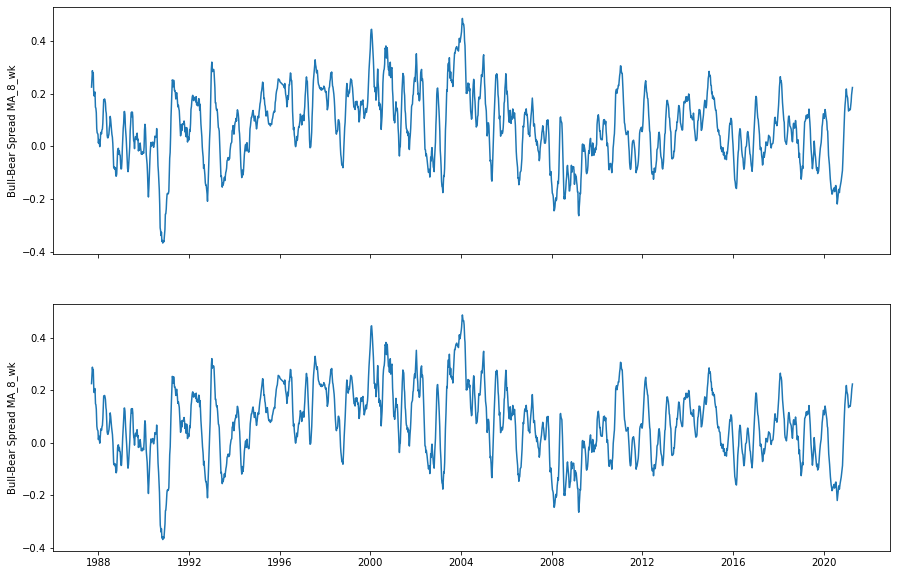

In [21]:
## Check whether the interpolation to daily frequency was a correct approach

fig, ax = plt.subplots(2,1, figsize=(15,10), sharex=True)
_ax1 = sns.lineplot(x=inv_sentiment.index, y=inv_sentiment['Bull-Bear Spread MA_8_wk'], ax=ax[0])
_ax2 = sns.lineplot(x=df_inv_sentiment.index, y=df_inv_sentiment['Bull-Bear Spread MA_8_wk'], ax=ax[1])
plt.show()

In [22]:
# EIA Data

eia_id = 'INTL.4008-8-WORL-MMTCD.A'
df_co2_emmissions = get_eia_data(eia_id)
df_co2_emmissions.tail()

,CO2_Em
Year,
2014,35328.511561
2015,35116.199154
2016,34559.643570
2017,35360.995674
2018,36227.769473


## <a id='data_organization'></a>
## <font color='darkblue'>__Data Organization__</font>

#### <font color='darkblue'>__Initialize__</font>

In [23]:
# Create Calendar Table
df_dates = create_date_table()
df_dates.set_index('Date', inplace = True)
df_dates.tail()

,DateID,Week_day,Day,Month,Week,Quarter,Year
Date,,,,,,,
2099-12-27,20991227,Sunday,27,12,52,4,2099
2099-12-28,20991228,Monday,28,12,53,4,2099
2099-12-29,20991229,Tuesday,29,12,53,4,2099
2099-12-30,20991230,Wednesday,30,12,53,4,2099
2099-12-31,20991231,Thursday,31,12,53,4,2099


In [24]:
# Create copies of the imported data that are being transformed

df_btc = df_btc_data.copy()
df_altcoin = df_altcoin_poloniex_data.copy()
df_fin_asset = df_asset_data.copy()
df_transactions = df_btc_tran.copy()
df_exchanges = df_cg_exchanges.copy()
df_markets = df_cg_markets.copy()
df_sentiments = df_inv_sentiment.copy()
df_emmissions = df_co2_emmissions.copy()


#### <font color='darkblue'>__Preprocess__</font>

In [25]:
# Add the Fin Assets Exchange Data to Exchange List 

exchanges_list_cg = pd.unique(df_exchanges['Id'].str.upper())
exchanges_list_cg= np.append(exchanges_list_cg, ['YAHOO'])
exchanges_list_cg.sort()
exchanges_list_cg

print(f"{exchanges_list_cg}")

['AAX' 'AEX' 'ALTERDICE' 'ATOMARS' 'BIBOX' 'BIDESK' 'BIGONE' 'BIKI'
 'BINANCE' 'BINANCE_US' 'BITBANK' 'BITCOIN_COM' 'BITFINEX' 'BITFLYER'
 'BITFOREX' 'BITGET' 'BITHUMB' 'BITHUMB_GLOBAL' 'BITKUB' 'BITMART'
 'BITMAX' 'BITOFFER' 'BITOPRO' 'BITPANDA' 'BITRUE' 'BITSO' 'BITSTAMP'
 'BITTREX' 'BKEX' 'BLOCKCHAIN_COM' 'BTCMARKETS' 'BTCTURK' 'BTC_ALPHA'
 'BVNEX' 'BW' 'CBX' 'CEX' 'CHANGELLY' 'COINBENE' 'COINCHECK' 'COINEAL'
 'COINHE' 'COINONE' 'COINSBIT' 'COINTIGER' 'CRYPTOLOGY' 'CRYPTO_COM'
 'DEXTRADE' 'DIGIFINEX' 'EMIREX' 'ETOROX' 'EXMARKETS' 'EXMO' 'FTX_SPOT'
 'FTX_US' 'GATE' 'GDAX' 'GEMINI' 'GMO_JAPAN' 'GOPAX' 'HITBTC' 'HOO'
 'HOTBIT' 'HUOBI' 'INDEPENDENT_RESERVE' 'INDODAX' 'ITBIT' 'KORBIT'
 'KRAKEN' 'KUCOIN' 'KUNA' 'LATOKEN' 'LBANK' 'LUNO' 'MAX_MAICOIN'
 'MERCADO_BITCOIN' 'MXC' 'NARKASA' 'NICE_HASH' 'NOMINEX' 'OCEANEX'
 'OKCOIN' 'OKEX' 'OMGFIN' 'P2PB2B' 'PARIBU' 'PHEMEX' 'POLONIEX' 'PROBIT'
 'QUOINE' 'SUSHISWAP' 'THODEX' 'UNISWAP' 'UPBIT' 'VCC' 'WAZIRX' 'WHITEBIT'
 'XT' 'YAHOO' 'ZAIF' 'ZB']


In [26]:
# Add the Fin Assets Market data to Market List

markets_list_cg = pd.unique(df_markets['Symbol'].str.upper())
add_markets = np.unique(df_fin_asset['Symbol'])
markets_list_cg = np.append(markets_list_cg, add_markets)
markets_list_cg.sort()
markets_list_cg

print(f"{markets_list_cg}")

['AAVE' 'ADA' 'ALGO' 'AMP' 'ANKR' 'AR' 'ATOM' 'AVAX' 'BAT' 'BCH' 'BNB'
 'BNT' 'BSV' 'BTC' 'BTG' 'BTT' 'BUSD' 'CAKE' 'CDAI' 'CEL' 'CETH' 'CHZ'
 'CLF' 'COMP' 'CRO' 'CUSDC' 'DAI' 'DASH' 'DCR' 'DGB' 'DJI' 'DOGE' 'DOT'
 'EGLD' 'ENJ' 'EOS' 'ETC' 'ETH' 'FEI' 'FIL' 'FLOW' 'FTM' 'FTT' 'GCF' 'GRT'
 'GSPC' 'HBAR' 'HBTC' 'HNT' 'HOT' 'HT' 'ICX' 'IOST' 'IXIC' 'KCS' 'KLAY'
 'KSM' 'LEO' 'LINK' 'LTC' 'LUNA' 'MANA' 'MATIC' 'MIOTA' 'MKR' 'NEAR' 'NEO'
 'NEXO' 'OKB' 'OMG' 'OMI' 'ONE' 'ONT' 'QTUM' 'RSR' 'RUNE' 'RVN' 'SC' 'SNX'
 'SOL' 'STX' 'SUSHI' 'THETA' 'TRX' 'TSLA' 'UMA' 'UNI' 'USDC' 'USDT' 'UST'
 'VET' 'VGX' 'WAVES' 'WBTC' 'WIN' 'XDC' 'XEM' 'XLM' 'XMR' 'XRP' 'XSUSHI'
 'XTZ' 'YFI' 'ZEC' 'ZIL' 'ZRX']


In [27]:
# Create ID Columns for Exchanges

exchange_mapping = {}
for exchange_id, exchange_value in enumerate(exchanges_list_cg):
    exchange_mapping.update({exchange_value:exchange_id+1})
    
value_mapper(df_exchanges, 'Id', 'ExchangeID', exchange_mapping)
df_exchanges[['Id', 'Name', 'ExchangeID']].sort_values(by='Name').tail()

,Id,Name,ExchangeID
24,zb,ZB,101
79,zaif,Zaif,100
36,bitflyer,bitFlyer,14
61,etorox,eToroX,51
80,itbit,itBit,67


In [28]:
# Create ID Columns for Markets

market_mapping = {}
for market_id, market_value in enumerate(markets_list_cg):
    market_mapping.update({market_value:market_id+1})

value_mapper(df_markets, 'Symbol', 'MarketID', market_mapping)
df_markets[['Id', 'Symbol', 'MarketID']].sort_values(by='Id').tail()

,Id,Symbol,MarketID
91,xdce-crowd-sale,xdc,96
98,xsushi,xsushi,101
73,yearn-finance,yfi,103
57,zcash,zec,104
61,zilliqa,zil,105


In [29]:
# Map the Exchange and Market IDs to the BTC, Altcoin and Fin Asset Data

value_mapper(df_btc, 'Exchange', 'ExchangeID', exchange_mapping)
value_mapper(df_btc, 'Market', 'MarketID', market_mapping)

value_mapper(df_altcoin, 'Exchange', 'ExchangeID', exchange_mapping)
value_mapper(df_altcoin, 'Market', 'MarketID', market_mapping)

value_mapper(df_fin_asset, 'Source', 'ExchangeID', exchange_mapping)
value_mapper(df_fin_asset, 'Symbol', 'MarketID', market_mapping)

value_mapper(df_transactions, 'Market', 'MarketID', market_mapping)


,Cost_per_TR,Num_TR_per_Block,Num_TR_ex_pop,Market,MarketID
2009-01-02,0.000000,1.000000,1,BTC,14
2009-01-03,0.000000,1.000000,0,BTC,14
2009-01-04,0.000000,1.000000,0,BTC,14
2009-01-05,0.000000,1.000000,0,BTC,14
2009-01-06,0.000000,1.000000,0,BTC,14
...,...,...,...,...,...
2021-04-09,191.393851,2136.315789,319653,BTC,14
2021-04-10,214.295361,1905.006369,293751,BTC,14
2021-04-11,229.706618,1747.924138,249489,BTC,14
2021-04-12,204.765103,2023.395833,286658,BTC,14


In [30]:
## Create mapping table of the columns for Preprocessing

# Create dictionary of the dataframes
data_frames = {
    'BTC Data': df_btc,
    'Altcoin Data': df_altcoin,
    'Fin Assets Data': df_fin_asset,
    'Transaction Data': df_transactions,
    'Exchanges Data': df_exchanges,
    'Markets Data': df_markets,
    'Sentiments Data': df_sentiments,
    'Emmissions Data': df_emmissions,
    'Date Table': df_dates
}

# Organize the Dataframe column names and their mapping into a dictionary
data_frames_col_translate = {}
column_list = []
column_map = {}
for df_name, df in data_frames.items():
    column_list.append(
        [{col: col.replace(" ", "") for col in df.columns}]
    )
    for col in column_list:
        data_frames_col_translate[df_name] = col

#data_frames_col_translate

#### <font color='darkblue'>__Rearrange and Save__</font>

In [31]:
# Preprocess Data for SQL DB load

df_btc_prep = df_preprocess(df_btc, 'BTC Data', data_frames_col_translate)
df_altcoin_prep = df_preprocess(df_altcoin, 'Altcoin Data', data_frames_col_translate)
df_fin_asset_prep = df_preprocess(df_fin_asset, 'Fin Assets Data', data_frames_col_translate)
df_transactions_prep = df_preprocess(df_transactions, 'Transaction Data', data_frames_col_translate)
df_sentiments_prep = df_preprocess(df_sentiments, 'Sentiments Data', data_frames_col_translate)
df_emmisisons_prep = df_preprocess(df_emmissions, 'Emmissions Data', data_frames_col_translate)
df_exchanges_prep = df_preprocess(df_exchanges, 'Exchanges Data', data_frames_col_translate)
df_markets_prep = df_preprocess(df_markets, 'Markets Data', data_frames_col_translate)
df_dates_prep = df_preprocess(df_dates, 'Date Table', data_frames_col_translate)

# Additional manual preprocessing

df_markets_prep = df_markets_prep.drop('Date', axis=1)
df_exchanges_prep = df_exchanges_prep.drop('Date', axis=1)
df_exchanges_prep['Trading_Inc'] = df_exchanges_prep['Has_Trading_Incentive'].replace({True: 1, False: 0})


In [32]:
# Saving the data into csv Files for external DB load

df_save_to_csv(data_frames)

<p> <strong>(Optional Step)</strong> The Data Organization into Database itself happens outside of the notebook: 
    <li>Create Tables ralated to each other</li>
    <li>Load the csv-files coming as output from this notebook into the tables</li>
    <li>Query the Dataset as an input for further analysis</li>

Further down we are going to demonstrate a Wrangling and Transformation process within the notebook using Python...

</p>

## <a id='data_wrangling'></a>
## <font color='darkblue'>__Data Wrangling__</font>

<h4>Simulation of an ETL-Process</h4>
<p>We are going to use recursive 
    <strong>Merge->Check->Impute->Transform/Aggregate</strong>
    process on all the relevant Datasources and put together the final dataset for EDA and Modeling</p>

### <font color='darkblue'>__BTC Dataset__</font>

#### <font color='blue'>__Merge Data__</font>

In [33]:
btc_data_prepared = df_btc_prep.merge(df_exchanges_prep[['Id', 'ExchangeID']], how='left', 
                                      left_on='ExchangeID', right_on='ExchangeID').drop(columns=['ExchangeID'])
btc_data_prepared['Exchange'] = btc_data_prepared['Id'].str.upper()
btc_data_prepared['Month'] = btc_data_prepared['Date'].dt.month_name()
btc_data_prepared['Year'] = btc_data_prepared['Date'].dt.year
btc_data_prepared = btc_data_prepared[['Date', 'WeightedPrice', 'Volume_BTC', 'Exchange', 'Year', 'Month']]
btc_data_prepared.tail()

,Date,WeightedPrice,Volume_BTC,Exchange,Year,Month
18519,2021-04-13,62007.654271,1753.887293,POLONIEX,2021,April
18520,2021-04-13,62353.412081,6033.352095,KRAKEN,2021,April
18521,2021-04-13,62121.551005,5617.564271,BITSTAMP,2021,April
18522,2021-04-13,62308.619925,196.629918,CEX,2021,April
18523,2021-04-14,63558.081850,1493.201851,POLONIEX,2021,April


#### <font color='blue'>__Check for N/As and zeros__</font>

In [34]:
btc_data_prepared.isna().sum()

Date             0
WeightedPrice    0
Volume_BTC       0
Exchange         0
Year             0
Month            0
dtype: int64

In [35]:
btc_data_prepared.loc[(btc_data_prepared==0).any(axis=1)]

,Date,WeightedPrice,Volume_BTC,Exchange,Year,Month
105,2011-09-30,0.0,0.0,BITSTAMP,2011,September
106,2011-10-01,0.0,0.0,BITSTAMP,2011,October
108,2011-10-02,0.0,0.0,BITSTAMP,2011,October
134,2011-10-15,0.0,0.0,BITSTAMP,2011,October
137,2011-10-16,0.0,0.0,BITSTAMP,2011,October
...,...,...,...,...,...,...
16332,2019-12-26,0.0,0.0,BITFLYER,2019,December
16334,2019-12-27,0.0,0.0,BITFLYER,2019,December
16338,2019-12-28,0.0,0.0,BITFLYER,2019,December
16346,2019-12-29,0.0,0.0,BITFLYER,2019,December


In [36]:
btc_data_prepared = btc_data_prepared.replace(0, np.nan)

In [37]:
btc_data_prepared.isna().sum()

Date               0
WeightedPrice    679
Volume_BTC       680
Exchange           0
Year               0
Month              0
dtype: int64

#### <font color='blue'>__Data Imputation__</font>

In [38]:
btc_data_prepared['WeightedPrice_filled'] = btc_data_prepared.groupby(['Exchange', 'Year', 'Month'])['WeightedPrice'].transform(
    lambda grp: grp.fillna(np.mean(grp)))

btc_data_prepared['Volume_filled'] = btc_data_prepared.groupby(['Exchange', 'Year', 'Month'])['Volume_BTC'].transform(
    lambda grp: grp.fillna(np.mean(grp)))

btc_data_prepared

,Date,WeightedPrice,Volume_BTC,Exchange,Year,Month,WeightedPrice_filled,Volume_filled
0,2011-07-05,12.412727,5.500000,CBX,2011,July,12.412727,5.500000
1,2011-07-06,14.858192,17.700000,CBX,2011,July,14.858192,17.700000
2,2011-07-07,14.108995,32.350000,CBX,2011,July,14.108995,32.350000
3,2011-07-08,14.327586,11.600000,CBX,2011,July,14.327586,11.600000
4,2011-07-09,13.635976,37.150000,CBX,2011,July,13.635976,37.150000
...,...,...,...,...,...,...,...,...
18519,2021-04-13,62007.654271,1753.887293,POLONIEX,2021,April,62007.654271,1753.887293
18520,2021-04-13,62353.412081,6033.352095,KRAKEN,2021,April,62353.412081,6033.352095
18521,2021-04-13,62121.551005,5617.564271,BITSTAMP,2021,April,62121.551005,5617.564271
18522,2021-04-13,62308.619925,196.629918,CEX,2021,April,62308.619925,196.629918


#### <font color='blue'>__Transorm / Aggregate Data__</font>

In [39]:
btc_data_prepared = btc_data_prepared.groupby(['Date'], as_index=False).agg({'WeightedPrice_filled':'mean', 
                                                                             'Volume_filled': 'sum'})

In [40]:
btc_data_prepared.isna().sum()

Date                    0
WeightedPrice_filled    0
Volume_filled           0
dtype: int64

In [41]:
# Simple 30-Day Moving Average

btc_data_prepared['SMA_30'] = btc_data_prepared.loc[:,'WeightedPrice_filled'].rolling(window=30).mean().fillna(method='bfill')

In [42]:
# Exponential Moving Average

btc_data_prepared['EMA'] = btc_data_prepared.loc[:,'WeightedPrice_filled'].ewm(span=40, adjust=False).mean()

In [43]:
btc_data_prepared.set_index('Date', inplace=True)

In [44]:
## Bitcoin Dataset prepared
btc_data_prepared

,WeightedPrice_filled,Volume_filled,SMA_30,EMA
Date,,,,
2011-07-05,12.412727,5.500000,13.689184,12.412727
2011-07-06,14.858192,17.700000,13.689184,12.532018
2011-07-07,14.108995,32.350000,13.689184,12.608944
2011-07-08,14.327586,11.600000,13.689184,12.692780
2011-07-09,13.635976,37.150000,13.689184,12.738790
...,...,...,...,...
2021-04-10,59993.981260,11055.681140,57239.836434,55084.842965
2021-04-11,59765.842201,5037.291405,57343.243155,55313.184391
2021-04-12,60155.945696,8182.256491,57365.511752,55549.416650


### <font color='darkblue'>__Altcoin Dataset__</font>

#### <font color='blue'>__Merge Data__</font>

In [45]:
df_altcoin_prep.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36028 entries, 0 to 36027
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           36028 non-null  datetime64[ns]
 1   Open           36028 non-null  float64       
 2   High           36028 non-null  float64       
 3   Low            36028 non-null  float64       
 4   Close          36028 non-null  float64       
 5   Volume_BTC     36028 non-null  float64       
 6   Volume_Market  36028 non-null  float64       
 7   WeightedPrice  36028 non-null  float64       
 8   Exchange       36028 non-null  object        
 9   Market         36028 non-null  object        
 10  ExchangeID     36028 non-null  int64         
 11  MarketID       36028 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(2)
memory usage: 3.3+ MB


In [46]:
altcoin_data_prepared = df_altcoin_prep.merge(df_markets_prep[['Symbol', 'MarketID']], how='left', 
                                      left_on='MarketID', right_on='MarketID').drop(columns=['MarketID'])
altcoin_data_prepared['Symbol'] = altcoin_data_prepared['Symbol'].str.upper()
altcoin_data_prepared['Month'] = altcoin_data_prepared['Date'].dt.month_name()
altcoin_data_prepared['Year'] = altcoin_data_prepared['Date'].dt.year
altcoin_data_prepared_copy = altcoin_data_prepared.copy()
altcoin_data_prepared = altcoin_data_prepared[['Date', 'WeightedPrice', 'Symbol', 'Year', 'Month']]
altcoin_data_prepared.tail()

,Date,WeightedPrice,Symbol,Year,Month
36023,2021-04-14,0.000034,ZRX,2021,April
36024,2021-04-14,0.000381,ATOM,2021,April
36025,2021-04-14,0.000007,MATIC,2021,April
36026,2021-04-14,0.000002,DOGE,2021,April
36027,2021-04-14,0.000149,OMG,2021,April


#### <font color='blue'>__Check for N/As and zeros__</font>

In [47]:
altcoin_data_prepared.isna().sum()

Date             0
WeightedPrice    0
Symbol           0
Year             0
Month            0
dtype: int64

In [48]:
altcoin_data_prepared.loc[(altcoin_data_prepared==0).any(axis=1)]

,Date,WeightedPrice,Symbol,Year,Month


#### <font color='blue'>__Transorm / Aggregate Data__</font>

In [49]:
altcoin_data_grouped = altcoin_data_prepared.groupby(['Date'], as_index=False).agg({'WeightedPrice':'mean'})
altcoin_data_grouped.set_index('Date', inplace=True)
altcoin_data_grouped = altcoin_data_grouped.merge(btc_data_prepared['WeightedPrice_filled'], how='left',
                                                   left_index=True, right_index=True)

altcoin_data_grouped['WeightedPrice_USD'] = altcoin_data_grouped['WeightedPrice'] * altcoin_data_grouped['WeightedPrice_filled']
altcoin_data_grouped.drop(columns=['WeightedPrice', 'WeightedPrice_filled'], inplace=True)

In [50]:
# Exponential Moving Average

altcoin_data_grouped['Altcoin_EMA'] = altcoin_data_grouped.loc[:,'WeightedPrice_USD'].ewm(span=40, adjust=False).mean()

### <font color='darkblue'>__Consolidate Bitcoin and Altcoin Data__</font>

#### <font color='blue'>__Merge Data__</font>

In [51]:
btc_altcoin_merged = btc_data_prepared.merge(altcoin_data_grouped['Altcoin_EMA'], how='left', left_index=True, right_index=True)
btc_altcoin_merged['Altcoin_EMA_filled'] = btc_altcoin_merged['Altcoin_EMA'].fillna(
    value=btc_altcoin_merged['Altcoin_EMA'].rolling(window=30, center=True, min_periods=2).mean())

#### <font color='blue'>__Check for N/As and zeros__</font>

In [52]:
btc_altcoin_merged.isna().sum()

WeightedPrice_filled      0
Volume_filled             0
SMA_30                    0
EMA                       0
Altcoin_EMA             928
Altcoin_EMA_filled      915
dtype: int64

In [53]:
btc_altcoin_merged[btc_altcoin_merged['Altcoin_EMA'].isna()]

,WeightedPrice_filled,Volume_filled,SMA_30,EMA,Altcoin_EMA,Altcoin_EMA_filled
Date,,,,,,
2011-07-05,12.412727,5.500000,13.689184,12.412727,NaN,NaN
2011-07-06,14.858192,17.700000,13.689184,12.532018,NaN,NaN
2011-07-07,14.108995,32.350000,13.689184,12.608944,NaN,NaN
2011-07-08,14.327586,11.600000,13.689184,12.692780,NaN,NaN
2011-07-09,13.635976,37.150000,13.689184,12.738790,NaN,NaN
...,...,...,...,...,...,...
2014-01-13,827.853860,33643.133094,749.862232,767.080740,NaN,21.345291
2014-01-14,828.423733,14366.375018,749.310752,770.073081,NaN,21.107780
2014-01-15,838.770010,19729.282873,752.405631,773.424151,NaN,20.871897


In [54]:
btc_altcoin_merged.isna().sum()

WeightedPrice_filled      0
Volume_filled             0
SMA_30                    0
EMA                       0
Altcoin_EMA             928
Altcoin_EMA_filled      915
dtype: int64

In [55]:
## Check for the missing values in the Altcoin EMA
btc_altcoin_merged.head(850)

,WeightedPrice_filled,Volume_filled,SMA_30,EMA,Altcoin_EMA,Altcoin_EMA_filled
Date,,,,,,
2011-07-05,12.412727,5.500000,13.689184,12.412727,NaN,NaN
2011-07-06,14.858192,17.700000,13.689184,12.532018,NaN,NaN
2011-07-07,14.108995,32.350000,13.689184,12.608944,NaN,NaN
2011-07-08,14.327586,11.600000,13.689184,12.692780,NaN,NaN
2011-07-09,13.635976,37.150000,13.689184,12.738790,NaN,NaN
...,...,...,...,...,...,...
2013-10-27,185.613428,16583.386034,142.812223,145.339283,NaN,NaN
2013-10-28,190.990829,17959.686920,145.011107,147.566187,NaN,NaN
2013-10-29,196.803218,25333.327997,147.377760,149.967994,NaN,NaN


#### <font color='blue'>__Data Imputation__</font>

In [56]:
## Drop observations before 2014
btc_altcoin_prepared = btc_altcoin_merged[btc_altcoin_merged.index>='2014-01-05']

In [57]:
btc_altcoin_prepared.drop('Altcoin_EMA', axis=1, inplace=True)

In [58]:
btc_altcoin_prepared.rename(columns={'WeightedPrice_filled': 'WeightedPrice', 'Volume_filled': 'Volume', 
                                     'EMA': 'EMA_40', 'Altcoin_EMA_filled': 'Altcoin_EMA_40'}, inplace=True)

In [59]:
btc_altcoin_prepared.isna().sum()

WeightedPrice     0
Volume            0
SMA_30            0
EMA_40            0
Altcoin_EMA_40    0
dtype: int64

#### <font color='blue'>__Transorm / Aggregate Data__</font>

In [60]:
## Merged Bitcoin dataset with aggregate Altcoin Prices
btc_altcoin_prepared.tail()

,WeightedPrice,Volume,SMA_30,EMA_40,Altcoin_EMA_40
Date,,,,,
2021-04-10,59993.981260,11055.681140,57239.836434,55084.842965,2014.394534
2021-04-11,59765.842201,5037.291405,57343.243155,55313.184391,2021.233485
2021-04-12,60155.945696,8182.256491,57365.511752,55549.416650,2029.017524
2021-04-13,62197.809321,13601.433577,57426.951016,55873.728487,2036.690671
2021-04-14,63558.081850,1493.201851,57642.358519,56248.574993,2046.391009


### <font color='darkblue'>__Add the Prices of Top10 Altcoins as predictors__</font>

In [61]:
altcoin_data_prepared_copy.tail()

,Date,Open,High,Low,Close,Volume_BTC,Volume_Market,WeightedPrice,Exchange,Market,ExchangeID,Symbol,Month,Year
36023,2021-04-14,0.000036,0.000037,0.000033,0.000034,0.357964,1.046320e+04,0.000034,POLONIEX,ZRX,88,ZRX,April,2021
36024,2021-04-14,0.000378,0.000402,0.000359,0.000386,4.861139,1.275654e+04,0.000381,POLONIEX,ATOM,88,ATOM,April,2021
36025,2021-04-14,0.000007,0.000007,0.000006,0.000006,0.629589,9.655308e+04,0.000007,POLONIEX,MATIC,88,MATIC,April,2021
36026,2021-04-14,0.000001,0.000002,0.000001,0.000002,351.840212,1.793033e+08,0.000002,POLONIEX,DOGE,88,DOGE,April,2021
36027,2021-04-14,0.000153,0.000156,0.000140,0.000145,0.364946,2.457297e+03,0.000149,POLONIEX,OMG,88,OMG,April,2021


In [62]:
altcoin_data_prepared_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36028 entries, 0 to 36027
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           36028 non-null  datetime64[ns]
 1   Open           36028 non-null  float64       
 2   High           36028 non-null  float64       
 3   Low            36028 non-null  float64       
 4   Close          36028 non-null  float64       
 5   Volume_BTC     36028 non-null  float64       
 6   Volume_Market  36028 non-null  float64       
 7   WeightedPrice  36028 non-null  float64       
 8   Exchange       36028 non-null  object        
 9   Market         36028 non-null  object        
 10  ExchangeID     36028 non-null  int64         
 11  Symbol         36028 non-null  object        
 12  Month          36028 non-null  object        
 13  Year           36028 non-null  int64         
dtypes: datetime64[ns](1), float64(7), int64(2), object(4)
memory usage: 4.

#### <font color='blue'>__Merge__</font>

In [63]:
altcoin_for_top10 = altcoin_data_prepared.merge(altcoin_data_prepared_copy[['Date', 'Symbol', 'Volume_BTC']], 
                                                left_on=['Date', 'Symbol'], right_on=['Date', 'Symbol'])
top10_altcoin = pd.DataFrame(altcoin_for_top10.groupby('Symbol')['Volume_BTC'].sum().nlargest(10))
top10 = top10_altcoin.reset_index()['Symbol']
altcoin_data_to_merge = altcoin_data_prepared.loc[altcoin_data_prepared['Symbol'].isin(top10)]
altcoin_data_to_merge.set_index('Date', inplace=True)
altcoin_data_to_merge = altcoin_data_to_merge.merge(btc_data_prepared['WeightedPrice_filled'], 
                                                    how='left', left_index=True, right_index=True)
altcoin_data_to_merge['WeightedPrice_USD'] = altcoin_data_to_merge['WeightedPrice'] * altcoin_data_to_merge['WeightedPrice_filled']
altcoin_data_to_pivot = altcoin_data_to_merge[['WeightedPrice_USD', 'Symbol']]
altcoin_data_to_pivot

,WeightedPrice_USD,Symbol
Date,,
2014-01-18,22.715625,LTC
2014-01-19,23.241787,LTC
2014-01-20,23.483508,LTC
2014-01-21,23.338116,LTC
2014-01-21,0.001847,DOGE
...,...,...
2021-04-14,1.794880,XRP
2021-04-14,270.498112,LTC
2021-04-14,0.031779,SC


In [64]:
altcoin_data_pivoted = altcoin_data_to_pivot.pivot_table('WeightedPrice_USD', ['Date'], 'Symbol')
altcoin_data_pivoted['Year'] = altcoin_data_pivoted.index.year
altcoin_data_pivoted['Month'] = altcoin_data_pivoted.index.month_name()
altcoin_data_pivoted

Symbol,DASH,DOGE,ETC,ETH,LTC,SC,XEM,XMR,XRP,ZEC,Year,Month
Date,,,,,,,,,,,,
2014-01-18,NaN,NaN,NaN,NaN,22.715625,NaN,NaN,NaN,NaN,NaN,2014,January
2014-01-19,NaN,NaN,NaN,NaN,23.241787,NaN,NaN,NaN,NaN,NaN,2014,January
2014-01-20,NaN,NaN,NaN,NaN,23.483508,NaN,NaN,NaN,NaN,NaN,2014,January
2014-01-21,NaN,0.001847,NaN,NaN,23.338116,NaN,NaN,NaN,NaN,NaN,2014,January
2014-01-22,NaN,0.001882,NaN,NaN,23.155726,NaN,NaN,NaN,NaN,NaN,2014,January
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-10,277.270584,0.062394,18.025192,2145.089000,235.140410,0.028197,0.412159,290.045702,1.230477,202.499485,2021,April
2021-04-11,286.013024,0.072914,18.787990,2142.612615,253.059931,0.026895,0.436888,313.229791,1.393739,219.874948,2021,April
2021-04-12,286.217779,0.070984,17.900003,2145.091844,248.921092,0.026469,0.421693,329.422380,1.387196,224.231889,2021,April


#### <font color='blue'>__Check for N/As and zeros__</font>

In [65]:
altcoin_data_to_pivot.isna().sum()

WeightedPrice_USD    0
Symbol               0
dtype: int64

In [66]:
altcoin_data_pivoted.isna().sum()

Symbol
DASH       20
DOGE        3
ETC       918
ETH       567
LTC         0
SC        584
XEM       437
XMR       121
XRP       208
ZEC      1014
Year        0
Month       0
dtype: int64

#### <font color='blue'>__Data imputation__</font>

In [67]:
# Fill the NaN with the mean price per year & month

years = list(set(altcoin_data_pivoted['Year']))
months = list(set(altcoin_data_pivoted['Month']))

for year in years:
    for month in months:
        for col in altcoin_data_pivoted.columns[:10]:
            altcoin_data_pivoted[col].fillna(altcoin_data_pivoted[col][(altcoin_data_pivoted['Year']==year) & (altcoin_data_pivoted['Month']==month)].mean(), inplace=True)
            
altcoin_data_pivoted

Symbol,DASH,DOGE,ETC,ETH,LTC,SC,XEM,XMR,XRP,ZEC,Year,Month
Date,,,,,,,,,,,,
2014-01-18,3.859244,0.000190,1.068133,1.492771,22.715625,0.000020,0.000324,0.518913,0.005730,9846.595939,2014,January
2014-01-19,3.859244,0.000190,1.068133,1.492771,23.241787,0.000020,0.000324,0.518913,0.005730,9846.595939,2014,January
2014-01-20,3.859244,0.000190,1.068133,1.492771,23.483508,0.000020,0.000324,0.518913,0.005730,9846.595939,2014,January
2014-01-21,3.859244,0.001847,1.068133,1.492771,23.338116,0.000020,0.000324,0.518913,0.005730,9846.595939,2014,January
2014-01-22,3.859244,0.001882,1.068133,1.492771,23.155726,0.000020,0.000324,0.518913,0.005730,9846.595939,2014,January
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-10,277.270584,0.062394,18.025192,2145.089000,235.140410,0.028197,0.412159,290.045702,1.230477,202.499485,2021,April
2021-04-11,286.013024,0.072914,18.787990,2142.612615,253.059931,0.026895,0.436888,313.229791,1.393739,219.874948,2021,April
2021-04-12,286.217779,0.070984,17.900003,2145.091844,248.921092,0.026469,0.421693,329.422380,1.387196,224.231889,2021,April


In [68]:
altcoin_data_pivoted.isna().sum()

Symbol
DASH     0
DOGE     0
ETC      0
ETH      0
LTC      0
SC       0
XEM      0
XMR      0
XRP      0
ZEC      0
Year     0
Month    0
dtype: int64

#### <font color='blue'>__Transorm / Aggregate Data__</font>

In [69]:
btc_dataset_merged = btc_altcoin_prepared.merge(altcoin_data_pivoted, how='left', left_index=True, right_index=True)
btc_altcoin_dataset_final = btc_dataset_merged.drop(['Year', 'Month'], axis=1)
btc_altcoin_dataset_final['Day_of_Week'] = btc_altcoin_dataset_final.index.day_name()
btc_altcoin_dataset_final

,WeightedPrice,Volume,SMA_30,EMA_40,Altcoin_EMA_40,DASH,DOGE,ETC,ETH,LTC,SC,XEM,XMR,XRP,ZEC,Day_of_Week
Date,,,,,,,,,,,,,,,,
2014-01-05,875.828236,45368.383442,748.087863,724.911649,22.728458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sunday
2014-01-06,934.305240,51652.618118,755.523877,735.125970,22.744804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday
2014-01-07,859.062055,64146.502417,760.241317,741.171633,22.617520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday
2014-01-08,819.601283,45252.943437,758.550758,744.997469,22.437180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday
2014-01-09,818.046129,42175.233800,754.182001,748.560819,22.234312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-10,59993.981260,11055.681140,57239.836434,55084.842965,2014.394534,277.270584,0.062394,18.025192,2145.089000,235.140410,0.028197,0.412159,290.045702,1.230477,202.499485,Saturday
2021-04-11,59765.842201,5037.291405,57343.243155,55313.184391,2021.233485,286.013024,0.072914,18.787990,2142.612615,253.059931,0.026895,0.436888,313.229791,1.393739,219.874948,Sunday
2021-04-12,60155.945696,8182.256491,57365.511752,55549.416650,2029.017524,286.217779,0.070984,17.900003,2145.091844,248.921092,0.026469,0.421693,329.422380,1.387196,224.231889,Monday


In [70]:
btc_altcoin_dataset_final.isna().sum()

WeightedPrice      0
Volume             0
SMA_30             0
EMA_40             0
Altcoin_EMA_40     0
DASH              13
DOGE              13
ETC               13
ETH               13
LTC               13
SC                13
XEM               13
XMR               13
XRP               13
ZEC               13
Day_of_Week        0
dtype: int64

In [71]:
btc_altcoin_dataset_final.loc[(btc_altcoin_dataset_final==0).any(axis=1)]

,WeightedPrice,Volume,SMA_30,EMA_40,Altcoin_EMA_40,DASH,DOGE,ETC,ETH,LTC,SC,XEM,XMR,XRP,ZEC,Day_of_Week
Date,,,,,,,,,,,,,,,,


In [72]:
btc_altcoin_dataset_final[btc_altcoin_dataset_final['ETH'].isna()]

,WeightedPrice,Volume,SMA_30,EMA_40,Altcoin_EMA_40,DASH,DOGE,ETC,ETH,LTC,SC,XEM,XMR,XRP,ZEC,Day_of_Week
Date,,,,,,,,,,,,,,,,
2014-01-05,875.828236,45368.383442,748.087863,724.911649,22.728458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sunday
2014-01-06,934.305240,51652.618118,755.523877,735.125970,22.744804,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday
2014-01-07,859.062055,64146.502417,760.241317,741.171633,22.617520,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Tuesday
2014-01-08,819.601283,45252.943437,758.550758,744.997469,22.437180,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Wednesday
2014-01-09,818.046129,42175.233800,754.182001,748.560819,22.234312,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Thursday
2014-01-10,831.916758,21786.599304,751.785785,752.626962,22.021732,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Friday
2014-01-11,878.696124,27442.746653,752.101663,758.776677,21.803990,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Saturday
2014-01-12,865.120279,24036.378016,751.261554,763.964170,21.581238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sunday
2014-01-13,827.853860,33643.133094,749.862232,767.080740,21.345291,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Monday


In [73]:
btc_altcoin_dataset_cleansed = btc_altcoin_dataset_final.dropna()

In [74]:
btc_altcoin_dataset_cleansed.isna().sum()

WeightedPrice     0
Volume            0
SMA_30            0
EMA_40            0
Altcoin_EMA_40    0
DASH              0
DOGE              0
ETC               0
ETH               0
LTC               0
SC                0
XEM               0
XMR               0
XRP               0
ZEC               0
Day_of_Week       0
dtype: int64

In [75]:
btc_altcoin_dataset_cleansed.head()

,WeightedPrice,Volume,SMA_30,EMA_40,Altcoin_EMA_40,DASH,DOGE,ETC,ETH,LTC,SC,XEM,XMR,XRP,ZEC,Day_of_Week
Date,,,,,,,,,,,,,,,,
2014-01-18,810.142750,9400.683829,772.778414,779.181401,22.715625,3.859244,0.000190,1.068133,1.492771,22.715625,0.00002,0.000324,0.518913,0.00573,9846.595939,Saturday
2014-01-19,821.264548,15823.922971,778.178989,781.234237,22.741291,3.859244,0.000190,1.068133,1.492771,23.241787,0.00002,0.000324,0.518913,0.00573,9846.595939,Sunday
2014-01-20,829.805923,12224.983605,785.480599,783.603588,22.777497,3.859244,0.000190,1.068133,1.492771,23.483508,0.00002,0.000324,0.518913,0.00573,9846.595939,Monday
2014-01-21,824.668417,10976.350239,791.911005,785.606750,22.235667,3.859244,0.001847,1.068133,1.492771,23.338116,0.00002,0.000324,0.518913,0.00573,9846.595939,Tuesday
2014-01-22,818.223544,11204.705313,797.829585,787.197813,21.715820,3.859244,0.001882,1.068133,1.492771,23.155726,0.00002,0.000324,0.518913,0.00573,9846.595939,Wednesday


### <font color='darkblue'>__Add the Injected data (Fin Assets, Sentiment data) as predictors and create the final dataset__</font>

#### <font color='blue'>__Merge__</font>

In [76]:
# Create a mapping dictionary and preprocess (subset, rename columns) the datasets

dct_features_inject = {
    'Fin Assets Data': [{
        'AdjClose': 'AdjClose',
        'Symbol': 'Symbol'}],
    'Transaction Data': [{
        'Cost_per_TR': 'Cost_per_TR',
        'Num_TR_per_Block': 'Num_TR_per_Block'}],
    'Sentiments Data': [{
        'Bull-BearSpreadMA_8_wk': 'Bu_Be_Spread_MA8'}]
}

df_to_preprocess_assets = df_fin_asset_prep.set_index('Date')
df_assets_to_merge = df_preprocess(df_to_preprocess_assets, 'Fin Assets Data', dct_features_inject)

df_to_preprocess_tr = df_transactions_prep.set_index('Date')
df_transactions_to_merge = df_preprocess(df_to_preprocess_tr, 'Transaction Data', dct_features_inject)

df_to_preprocess_sent = df_sentiments_prep.set_index('Date')
df_sentiments_to_merge = df_preprocess(df_to_preprocess_sent, 'Sentiments Data', dct_features_inject)

In [77]:
#Check the Headers

print(f"{df_assets_to_merge.tail()}\n" \
      f"{df_transactions_to_merge.tail()}\n" \
      f"{df_sentiments_to_merge.tail()}")


            Date    AdjClose Symbol
29067 2021-04-08  683.799988   TSLA
29068 2021-04-09  677.020020   TSLA
29069 2021-04-12  701.979980   TSLA
29070 2021-04-13  762.320007   TSLA
29071 2021-04-14  730.992676   TSLA
           Date  Cost_per_TR  Num_TR_per_Block
4480 2021-04-09   191.393851       2136.315789
4481 2021-04-10   214.295361       1905.006369
4482 2021-04-11   229.706618       1747.924138
4483 2021-04-12   204.765103       2023.395833
4484 2021-04-13   198.063134       2184.598592
            Date  Bu_Be_Spread_MA8
12259 2021-04-04          0.216601
12260 2021-04-05          0.218308
12261 2021-04-06          0.220014
12262 2021-04-07          0.221720
12263 2021-04-08          0.223427


In [78]:
# Fin Assets Dataset: Pivot the ticker prices after each other

df_assets_merge_prep = df_assets_to_merge.pivot_table('AdjClose', ['Date'], 'Symbol')
df_assets_merge_prep = df_assets_merge_prep[df_assets_merge_prep.index.year>=2014]
df_assets_merge_prep.head()

Symbol,CLF,DJI,GCF,GSPC,IXIC,TSLA
Date,,,,,,
2014-01-02,95.440002,16441.349609,1225.000000,1831.979980,4143.069824,30.020000
2014-01-03,93.959999,16469.990234,1238.400024,1831.369995,4131.910156,29.912001
2014-01-06,93.430000,16425.099609,1237.800049,1826.770020,4113.680176,29.400000
2014-01-07,93.669998,16530.939453,1229.400024,1837.880005,4153.180176,29.872000
2014-01-08,92.330002,16462.740234,1225.300049,1837.489990,4165.609863,30.256001


#### <font color='blue'>__Check for N/As and zeros__</font>

In [79]:
df_assets_merge_prep.isna().sum()

Symbol
CLF     15
DJI      0
GCF     16
GSPC     0
IXIC     0
TSLA     0
dtype: int64

In [80]:
df_assets_merge_prep[df_assets_merge_prep['GCF'].isna()]

Symbol,CLF,DJI,GCF,GSPC,IXIC,TSLA
Date,,,,,,
2014-07-03,NaN,17068.259766,NaN,1985.439941,4485.930176,45.849998
2014-11-28,NaN,17828.240234,NaN,2067.560059,4791.629883,48.903999
2014-12-24,NaN,18030.210938,NaN,2081.879883,4773.470215,44.452000
2016-10-10,NaN,18329.039062,NaN,2163.659912,5328.669922,40.189999
2016-11-11,NaN,18847.660156,NaN,2164.449951,5237.109863,37.712002
2017-07-03,NaN,21479.269531,NaN,2429.010010,6110.060059,70.524002
2017-11-24,NaN,23557.990234,NaN,2602.419922,6889.160156,63.110001
2018-01-29,65.559998,26439.480469,NaN,2853.530029,7466.509766,69.905998
2018-07-03,NaN,24174.820312,NaN,2713.219971,7502.669922,62.172001


In [81]:
df_assets_merge_prep.loc[(df_assets_merge_prep==0).any(axis=1)]

Symbol,CLF,DJI,GCF,GSPC,IXIC,TSLA
Date,,,,,,


#### <font color='blue'>__Data imputation__</font>

In [82]:
df_assets_merge_prep = df_assets_merge_prep.fillna(method='bfill')

In [83]:
df_assets_merge_prep.isna().sum()

Symbol
CLF     0
DJI     0
GCF     0
GSPC    0
IXIC    0
TSLA    0
dtype: int64

#### <font color='blue'>__Transform / Aggregate Data__</font>

In [84]:
df_tran_merge = df_transactions_to_merge.set_index('Date')
df_sent_merge = df_sentiments_to_merge.set_index('Date')

df_new_features = df_assets_merge_prep.merge(df_tran_merge, how='left', left_index=True, right_index=True).merge(df_sent_merge, how='left', left_index=True, right_index=True)

In [85]:
df_new_features.tail()

,CLF,DJI,GCF,GSPC,IXIC,TSLA,Cost_per_TR,Num_TR_per_Block,Bu_Be_Spread_MA8
Date,,,,,,,,,
2021-04-08,59.599998,33503.570312,1756.800049,4097.169922,13829.309570,683.799988,190.372114,2078.611940,0.223427
2021-04-09,59.320000,33800.601562,1743.300049,4128.799805,13900.190430,677.020020,191.393851,2136.315789,NaN
2021-04-12,59.700001,33745.398438,1731.199951,4127.990234,13850.000000,701.979980,204.765103,2023.395833,NaN
2021-04-13,60.180000,33677.269531,1746.199951,4141.589844,13996.099609,762.320007,198.063134,2184.598592,NaN
2021-04-14,62.869999,33726.078125,1736.800049,4124.669922,13860.406250,730.992676,NaN,NaN,NaN


In [86]:
df_new_features.isna().sum()

CLF                 0
DJI                 0
GCF                 0
GSPC                0
IXIC                0
TSLA                0
Cost_per_TR         1
Num_TR_per_Block    1
Bu_Be_Spread_MA8    4
dtype: int64

In [87]:
df_new_features.fillna(method='ffill', inplace=True)

#### <font color='darkred'>__Consolidate Final Dataset__</font>

In [88]:
btc_full_dataset = btc_altcoin_dataset_cleansed.merge(df_new_features, how='left', left_index=True, right_index=True)

In [89]:
btc_full_dataset.isna().sum()

WeightedPrice         0
Volume                0
SMA_30                0
EMA_40                0
Altcoin_EMA_40        0
DASH                  0
DOGE                  0
ETC                   0
ETH                   0
LTC                   0
SC                    0
XEM                   0
XMR                   0
XRP                   0
ZEC                   0
Day_of_Week           0
CLF                 823
DJI                 823
GCF                 823
GSPC                823
IXIC                823
TSLA                823
Cost_per_TR         823
Num_TR_per_Block    823
Bu_Be_Spread_MA8    823
dtype: int64

In [90]:
df_nas = btc_full_dataset[btc_full_dataset['CLF'].isna()]
df_nas

,WeightedPrice,Volume,SMA_30,EMA_40,Altcoin_EMA_40,DASH,DOGE,ETC,ETH,LTC,...,Day_of_Week,CLF,DJI,GCF,GSPC,IXIC,TSLA,Cost_per_TR,Num_TR_per_Block,Bu_Be_Spread_MA8
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-18,810.142750,9400.683829,772.778414,779.181401,22.715625,3.859244,0.000190,1.068133,1.492771,22.715625,...,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-19,821.264548,15823.922971,778.178989,781.234237,22.741291,3.859244,0.000190,1.068133,1.492771,23.241787,...,Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-20,829.805923,12224.983605,785.480599,783.603588,22.777497,3.859244,0.000190,1.068133,1.492771,23.483508,...,Monday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-25,802.882184,13531.798878,809.216967,789.642900,20.279801,3.859244,0.001437,1.068133,1.492771,22.366620,...,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-01-26,818.892047,17430.725621,812.379427,791.069688,19.799217,3.859244,0.001965,1.068133,1.492771,20.853717,...,Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-02,59348.771254,7553.439473,55494.451802,53576.008767,1963.573723,238.681173,0.059349,14.419971,2030.179028,205.780588,...,Friday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-03,58617.572332,6203.442282,55803.805727,53821.938697,1970.878834,237.424029,0.057445,13.796232,2075.303565,207.581237,...,Saturday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-04-04,57577.973114,4517.841426,56133.179389,54005.159888,1985.852073,258.633346,0.056426,13.282087,2041.315911,200.047182,...,Sunday,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
# Check if the missing observations are weekends...

df_nas_last_10 = df_nas[df_nas.columns[-10 :]]
df_nas_last_10.replace(np.nan, 1, inplace=True)
df_nas_last_10.groupby('Day_of_Week').count()

,CLF,DJI,GCF,GSPC,IXIC,TSLA,Cost_per_TR,Num_TR_per_Block,Bu_Be_Spread_MA8
Day_of_Week,,,,,,,,,
Friday,15,15,15,15,15,15,15,15,15
Monday,35,35,35,35,35,35,35,35,35
Saturday,378,378,378,378,378,378,378,378,378
Sunday,378,378,378,378,378,378,378,378,378
Thursday,10,10,10,10,10,10,10,10,10
Tuesday,3,3,3,3,3,3,3,3,3
Wednesday,4,4,4,4,4,4,4,4,4


In [92]:
# use forward fill to impute the data

btc_full_dataset_cleansed = btc_full_dataset.fillna(method='ffill')

In [93]:
btc_full_dataset_cleansed.dropna(inplace=True)

#### <font color='darkred'>__Save Final Dataset__</font>

In [94]:
btc_full_dataset_cleansed.to_csv('btc_full_dataset_cleansed.csv')

In [95]:
df_check = pd.read_csv('btc_full_dataset_cleansed.csv')
df_check.tail()

,Date,WeightedPrice,Volume,SMA_30,EMA_40,Altcoin_EMA_40,DASH,DOGE,ETC,ETH,...,Day_of_Week,CLF,DJI,GCF,GSPC,IXIC,TSLA,Cost_per_TR,Num_TR_per_Block,Bu_Be_Spread_MA8
2636,2021-04-10,59993.981260,11055.681140,57239.836434,55084.842965,2014.394534,277.270584,0.062394,18.025192,2145.089000,...,Saturday,59.320000,33800.601562,1743.300049,4128.799805,13900.190430,677.020020,191.393851,2136.315789,0.223427
2637,2021-04-11,59765.842201,5037.291405,57343.243155,55313.184391,2021.233485,286.013024,0.072914,18.787990,2142.612615,...,Sunday,59.320000,33800.601562,1743.300049,4128.799805,13900.190430,677.020020,191.393851,2136.315789,0.223427
2638,2021-04-12,60155.945696,8182.256491,57365.511752,55549.416650,2029.017524,286.217779,0.070984,17.900003,2145.091844,...,Monday,59.700001,33745.398438,1731.199951,4127.990234,13850.000000,701.979980,204.765103,2023.395833,0.223427
2639,2021-04-13,62197.809321,13601.433577,57426.951016,55873.728487,2036.690671,287.060305,0.082723,18.192859,2230.895475,...,Tuesday,60.180000,33677.269531,1746.199951,4141.589844,13996.099609,762.320007,198.063134,2184.598592,0.223427
2640,2021-04-14,63558.081850,1493.201851,57642.358519,56248.574993,2046.391009,300.590957,0.124574,18.837980,2349.067935,...,Wednesday,62.869999,33726.078125,1736.800049,4124.669922,13860.406250,730.992676,198.063134,2184.598592,0.223427


## EDA on the prepared dataset

In [96]:
# Descriptive Stat

btc_full_dataset_cleansed.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2641 entries, 2014-01-21 to 2021-04-14
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   WeightedPrice     2641 non-null   float64
 1   Volume            2641 non-null   float64
 2   SMA_30            2641 non-null   float64
 3   EMA_40            2641 non-null   float64
 4   Altcoin_EMA_40    2641 non-null   float64
 5   DASH              2641 non-null   float64
 6   DOGE              2641 non-null   float64
 7   ETC               2641 non-null   float64
 8   ETH               2641 non-null   float64
 9   LTC               2641 non-null   float64
 10  SC                2641 non-null   float64
 11  XEM               2641 non-null   float64
 12  XMR               2641 non-null   float64
 13  XRP               2641 non-null   float64
 14  ZEC               2641 non-null   float64
 15  Day_of_Week       2641 non-null   object 
 16  CLF               2641 n

In [97]:
btc_full_dataset_cleansed['Weekday'] = LabelEncoder().fit_transform(btc_full_dataset_cleansed['Day_of_Week'])

In [98]:
btc_full_dataset_cleansed_proc = btc_full_dataset_cleansed.drop('Day_of_Week', axis=1)

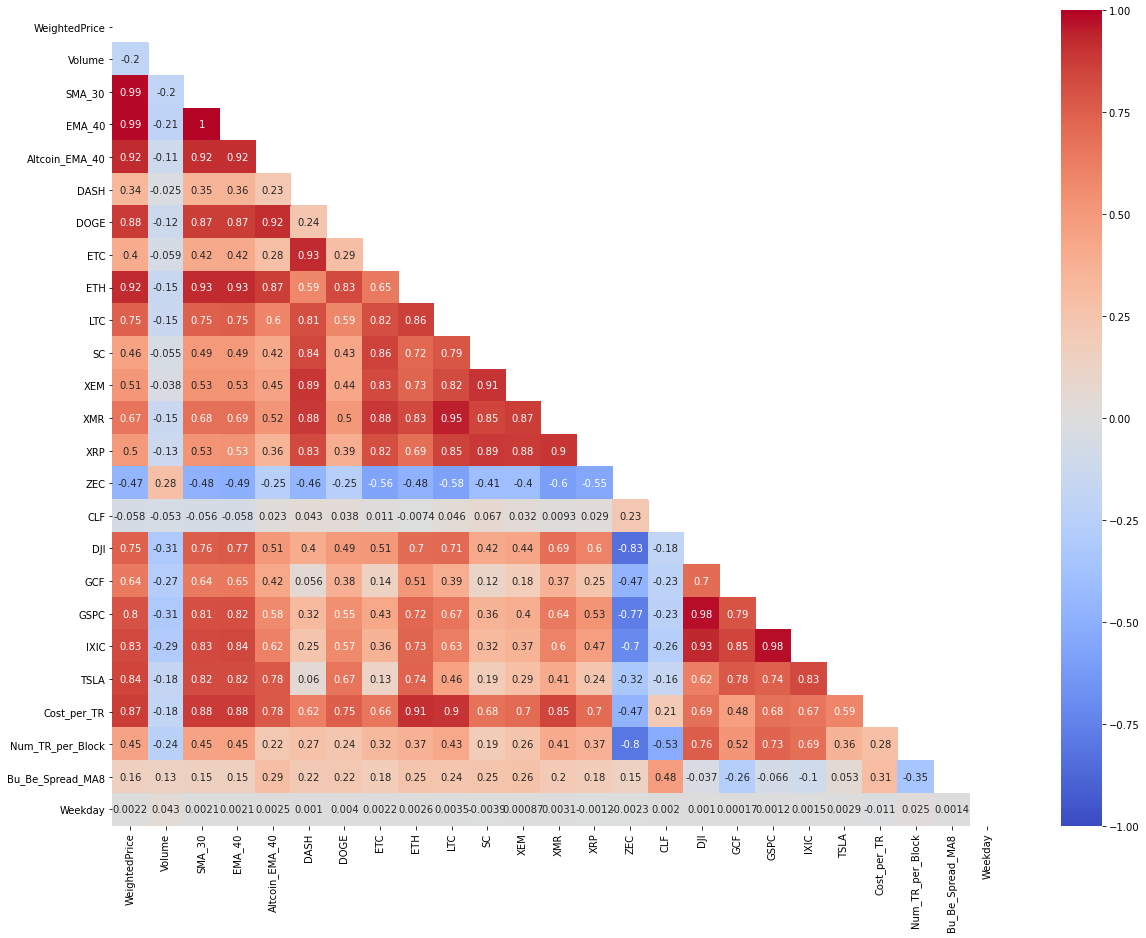

In [99]:
# Correlation Heatmap

fix, ax = plt.subplots(figsize=(20,15))
matrix = np.triu(btc_full_dataset_cleansed_proc.corr())
_ax = sns.heatmap(btc_full_dataset_cleansed_proc.corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', mask=matrix)
plt.show()

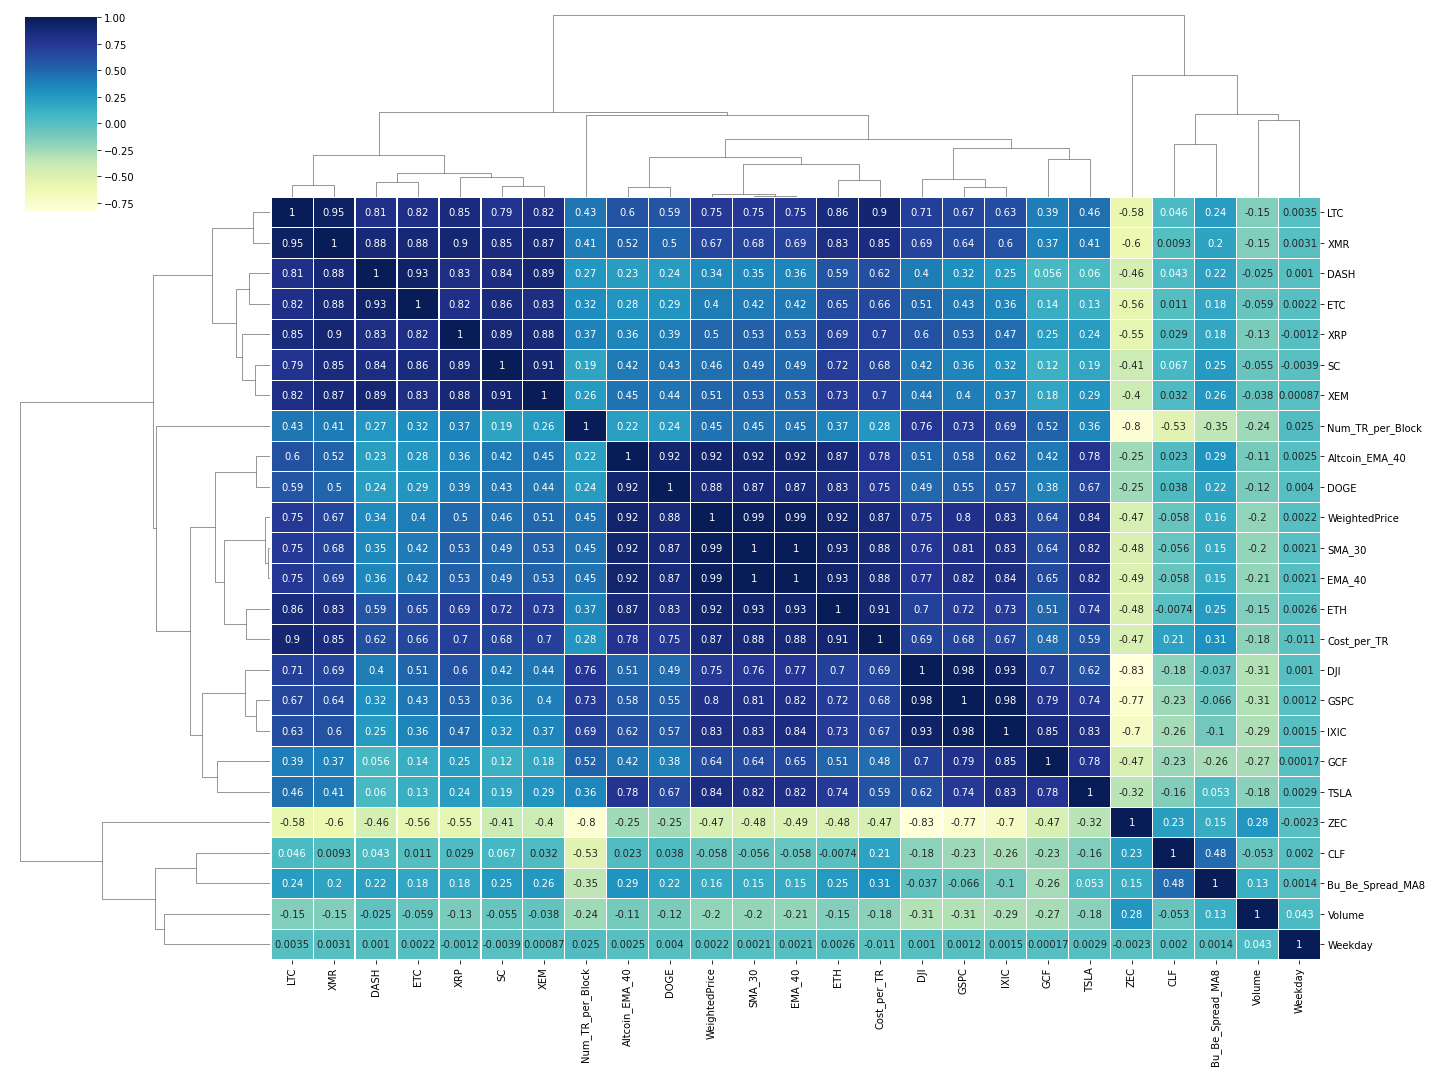

In [100]:
# Correlation clustermap

corrmat = btc_full_dataset_cleansed_proc.corr()
g = sns.clustermap(corrmat, annot=True, cmap ="YlGnBu", linewidths = 0.1, figsize=(20,15))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation = 0)
plt.show()

In [101]:
# Overall R2
overall_pearson_r = btc_full_dataset_cleansed_proc.corr().iloc[0,1]

In [102]:
overall_pearson_r

-0.19905118188688642

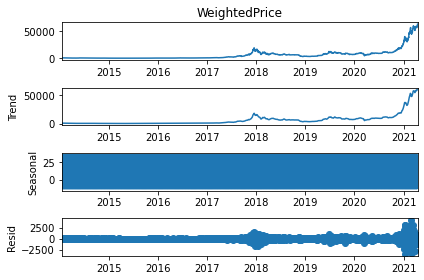

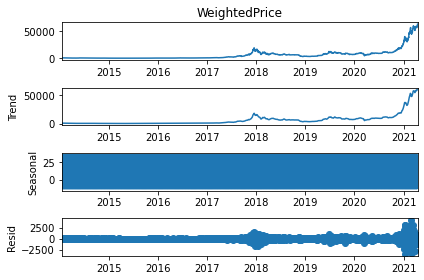

In [103]:
# Stationarity Test
decomposition = seasonal_decompose(btc_full_dataset_cleansed_proc['WeightedPrice'])
decomposition.plot()

In [104]:
# ARIMA model

from statsmodels.tsa.statespace.sarimax import SARIMAX

btc_full_dataset_cleansed_proc['log_diff'] = np.log(btc_full_dataset_cleansed_proc['WeightedPrice']).diff(periods=1)
btc_arima = btc_full_dataset_cleansed_proc[['log_diff']].dropna()

arima = SARIMAX(btc_arima['log_diff'], order=(0,1,1))
result = arima.fit()
result.summary()

C:\Users\akosr\anaconda3\envs\project-crypto\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

C:\Users\akosr\anaconda3\envs\project-crypto\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:               log_diff   No. Observations:                 2640
Model:               SARIMAX(0, 1, 1)   Log Likelihood                5315.436
Date:                Wed, 14 Apr 2021   AIC                         -10626.871
Time:                        23:32:19   BIC                         -10615.115
Sample:                    01-22-2014   HQIC                        -10622.615
                         - 04-14-2021                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.9910      0.002   -489.466      0.000      -0.995      -0.987
sigma2         0.0010   1.55e-05     67.068      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                 110.33   Jarque-Bera (JB):              2641.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.25   Skew:                            -0.38
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.84
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

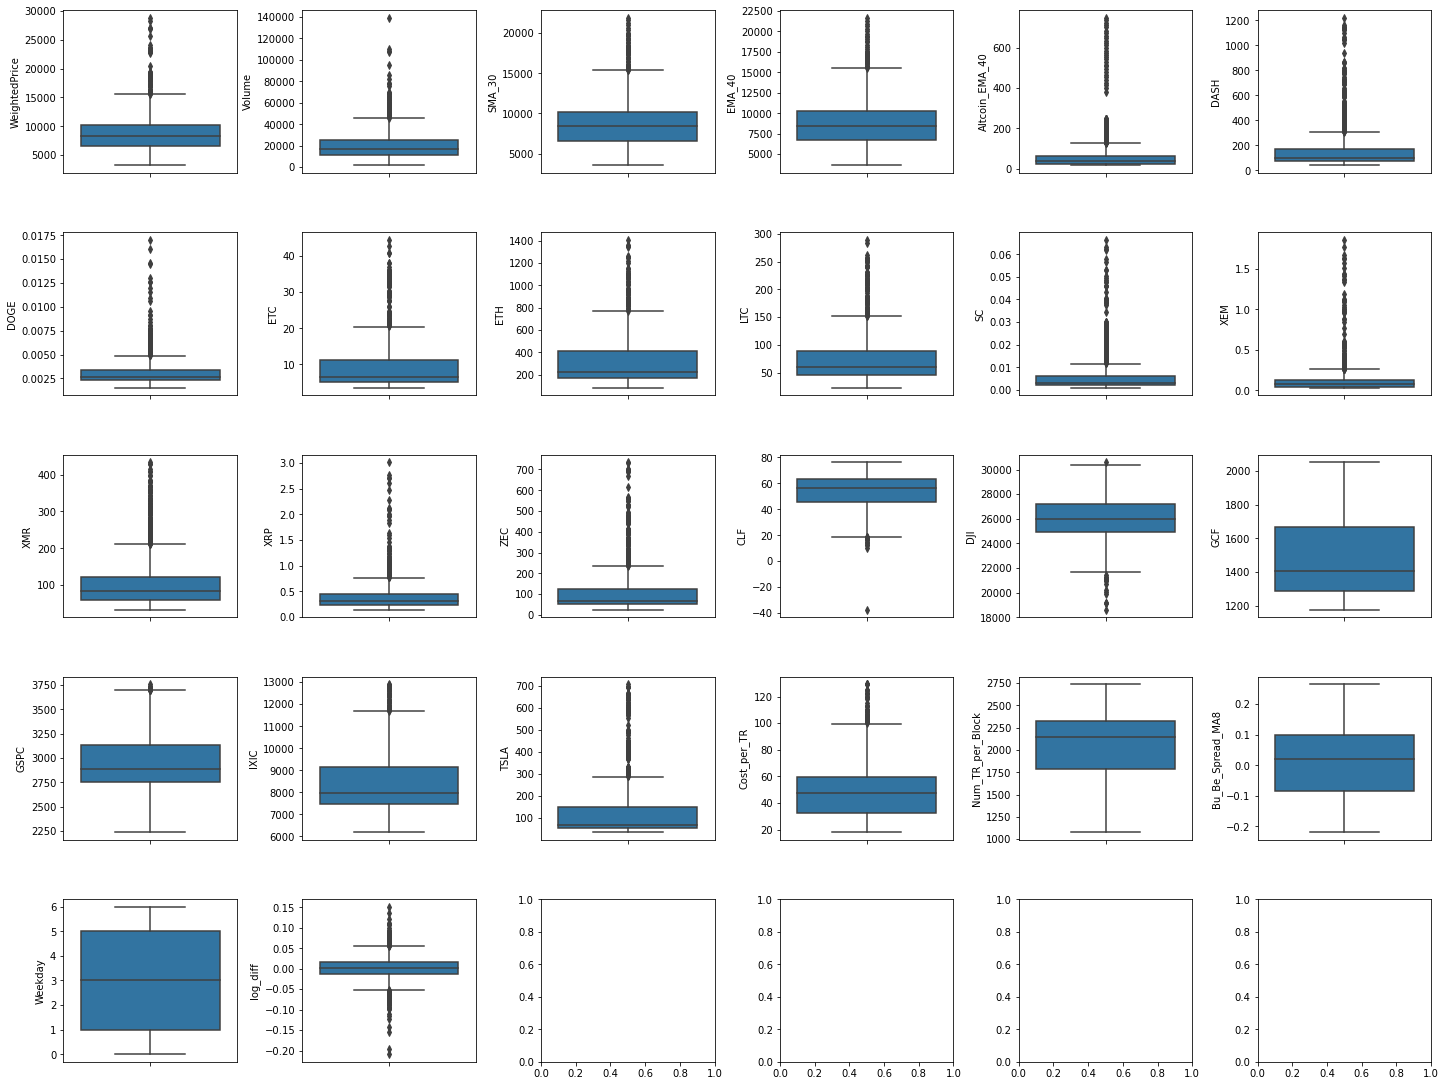

In [112]:
# Outlier Analysis - BoxPlots

from scipy import stats

btc_data_2018_2020 = btc_full_dataset_cleansed_proc[(btc_full_dataset_cleansed_proc.index.year>=2018) & (btc_full_dataset_cleansed_proc.index.year<2021)]

fig, axs = plt.subplots(ncols=6, nrows=5, figsize=(20, 15))
index = 0
axs = axs.flatten()
for label,content in btc_data_2018_2020.items():
    sns.boxplot(y=label, data=btc_data_2018_2020, ax=axs[index])
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.6, h_pad=5.0)

In [113]:
btc_full_dataset_cleansed_proc.describe()

,WeightedPrice,Volume,SMA_30,EMA_40,Altcoin_EMA_40,DASH,DOGE,ETC,ETH,LTC,...,DJI,GCF,GSPC,IXIC,TSLA,Cost_per_TR,Num_TR_per_Block,Bu_Be_Spread_MA8,Weekday,log_diff
count,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,...,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2641.000000,2640.000000
mean,6179.818083,28633.884938,5862.989719,5770.288760,98.917534,114.621803,0.003359,6.441185,229.987203,48.087400,...,22199.993289,1355.999621,2547.476074,6870.684872,112.291811,37.030029,1594.822487,0.039418,3.001893,0.001646
std,9683.625930,27583.568387,8801.221819,8486.244791,296.428136,182.498287,0.009593,7.251880,361.169411,57.384362,...,4600.209239,218.842066,540.421152,2381.181406,165.318491,35.010664,665.618719,0.105342,2.000851,0.032311
min,198.623915,977.247424,229.511855,238.159078,0.827169,0.134679,0.000088,0.633494,0.450749,1.351286,...,15372.799805,1050.800049,1741.890015,3996.959961,28.733999,3.442916,248.000000,-0.219132,0.000000,-0.209538
25%,466.844967,13077.227346,477.282572,498.062910,3.026792,4.308223,0.000220,1.068133,1.492771,3.891298,...,17792.750000,1221.199951,2078.580078,4933.500000,44.728001,8.904783,1078.064103,-0.030913,1.000000,-0.011239
50%,3502.877584,21070.259068,3535.532448,3617.121872,22.439726,69.114464,0.001756,4.487553,131.972169,34.581786,...,21813.669922,1285.000000,2470.500000,6383.770020,53.230000,29.240312,1724.252874,0.041456,3.000000,0.001341
75%,8557.803057,34596.089495,8505.375452,8564.361820,52.773879,133.912244,0.002726,8.513050,290.804623,62.109670,...,25942.369141,1396.199951,2886.979980,7962.879883,69.431999,50.109661,2162.382716,0.112502,5.000000,0.015741
max,63558.081850,419524.309216,57642.358519,56248.574993,2046.391009,1432.410643,0.124574,44.460417,2349.067935,352.847649,...,33800.601562,2051.500000,4141.589844,14095.469727,883.090027,215.236088,2734.440299,0.284761,6.000000,0.169922


In [114]:
btc_data_2018_2020.describe()

,WeightedPrice,Volume,SMA_30,EMA_40,Altcoin_EMA_40,DASH,DOGE,ETC,ETH,LTC,...,DJI,GCF,GSPC,IXIC,TSLA,Cost_per_TR,Num_TR_per_Block,Bu_Be_Spread_MA8,Weekday,log_diff
count,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,...,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000,1096.000000
mean,8672.357397,20095.369313,8564.493719,8529.290178,73.637671,172.030667,0.003158,9.501666,323.959015,77.189096,...,26108.939735,1477.332663,2958.723985,8516.889934,135.511708,50.053668,2028.262602,0.009758,3.003650,0.000675
std,3646.579821,13984.518093,3180.767354,3011.056719,101.394864,187.227495,0.001597,7.156372,232.095608,46.060445,...,1834.542138,237.027321,288.632341,1512.600789,145.999794,21.937667,395.229507,0.114721,2.001366,0.032113
min,3187.616399,1565.251086,3533.567761,3615.454927,17.249335,39.396377,0.001525,3.569461,82.953286,22.938785,...,18591.929688,1176.199951,2237.399902,6192.919922,35.793999,17.999771,1078.064103,-0.219132,0.000000,-0.209538
25%,6494.172886,10908.467402,6632.466062,6783.494416,24.580329,72.884235,0.002327,5.111134,170.383186,46.454799,...,24924.337891,1289.300049,2750.587524,7449.029785,56.808999,32.577920,1784.167742,-0.084013,1.000000,-0.011875
50%,8336.702060,16902.083735,8387.092048,8459.287263,37.532294,96.063719,0.002641,6.433898,227.185959,59.326579,...,25964.955078,1404.450012,2888.679932,7974.699951,66.774002,47.760205,2147.727848,0.019391,3.000000,0.000754
75%,10122.389884,24919.330646,10148.518100,10288.839088,66.446932,167.775958,0.003354,11.278866,411.140865,88.611372,...,27176.083008,1665.650024,3130.412598,9150.940430,149.144505,59.713818,2321.980825,0.098552,5.000000,0.015226
max,28828.279215,139224.056205,21919.672487,21685.443845,747.974505,1222.616595,0.017013,44.460417,1408.059147,289.168172,...,30606.480469,2051.500000,3756.070068,12899.419922,705.669983,129.199484,2734.440299,0.264654,6.000000,0.151882


### Pairplots

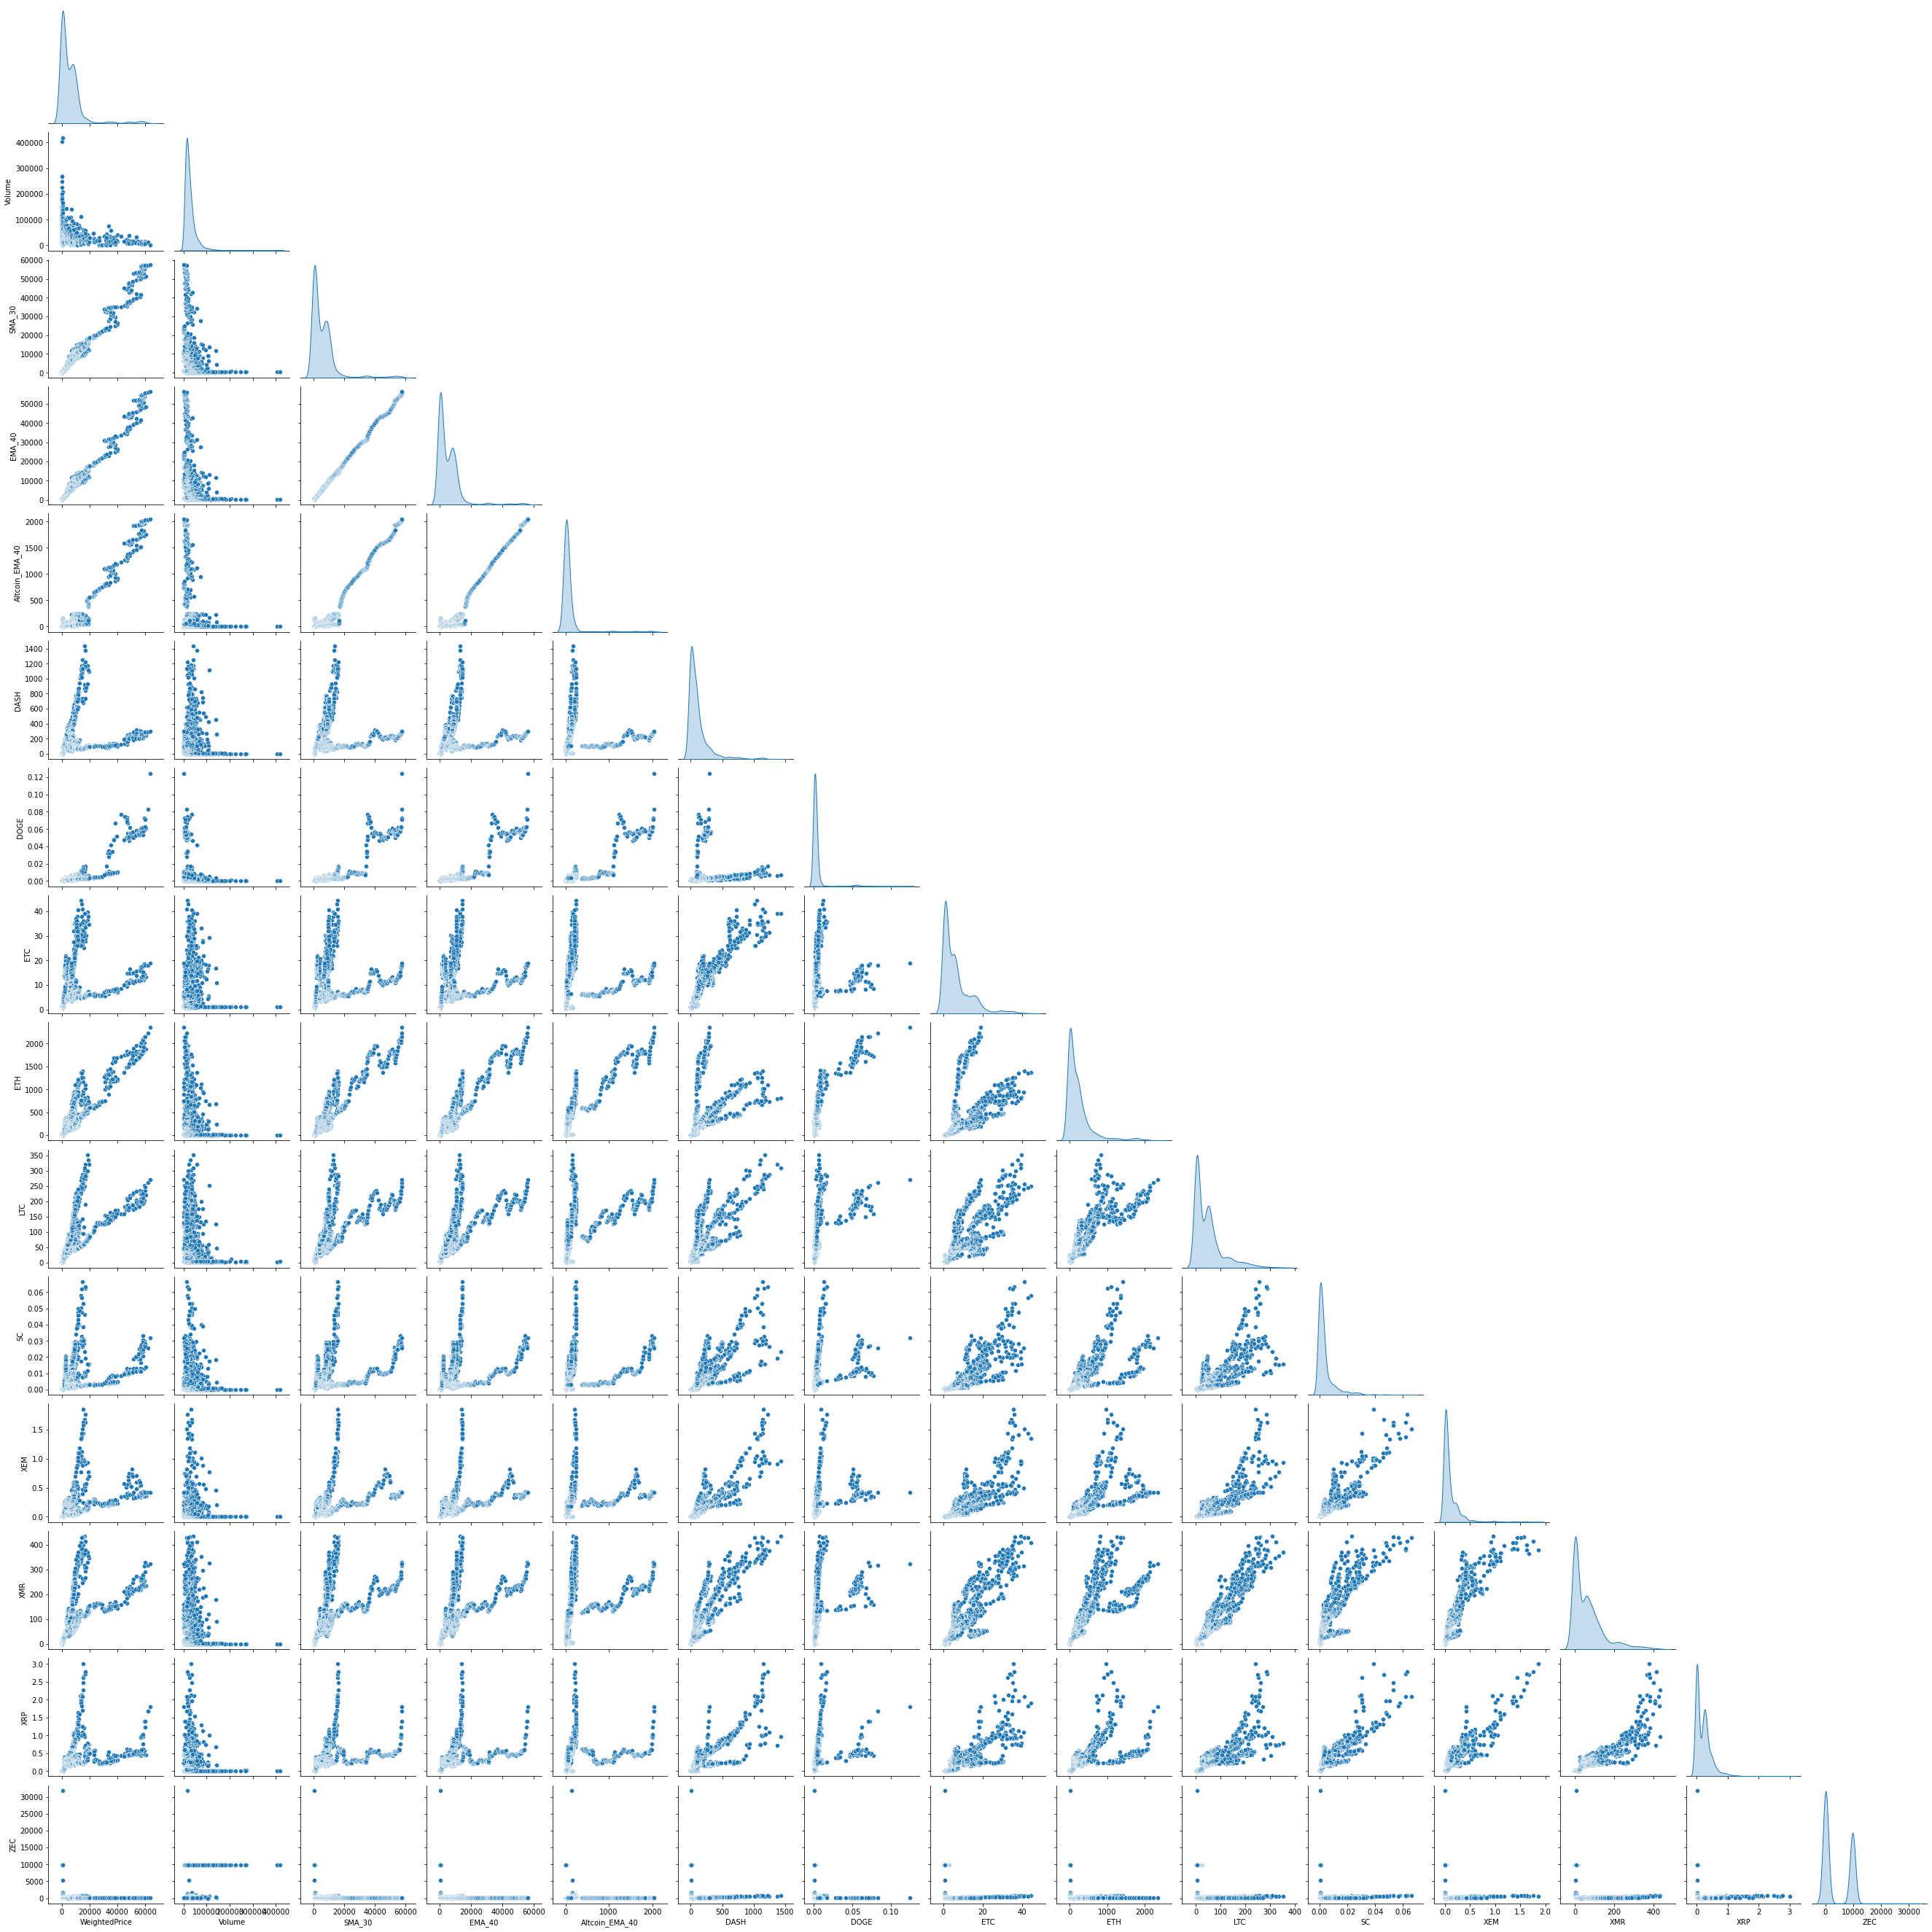

In [115]:
sns.pairplot(btc_altcoin_dataset_cleansed, diag_kind='kde', corner=True)

### Hypothesis Testing

In [116]:
btc_altcoin_OLS = btc_data_2018_2020[['WeightedPrice', 'Cost_per_TR']].reset_index().drop('Date', axis=1)

In [117]:
btc_altcoin_OLS

,WeightedPrice,Cost_per_TR
0,13869.630155,117.853617
1,14499.401551,122.635624
2,15262.696026,102.462144
3,15138.393342,102.933856
4,16304.159624,124.724362
...,...,...
1091,27068.550638,76.981920
1092,26957.032140,96.083448
1093,26926.557088,83.913571
1094,28162.202705,99.033068


In [118]:
btc_altcoin_OLS.describe()

,WeightedPrice,Cost_per_TR
count,1096.000000,1096.000000
mean,8672.357397,50.053668
std,3646.579821,21.937667
min,3187.616399,17.999771
25%,6494.172886,32.577920
50%,8336.702060,47.760205
75%,10122.389884,59.713818
max,28828.279215,129.199484


In [119]:
btc_altcoin_OLS_pc = btc_altcoin_OLS.pct_change()

In [120]:
np.isfinite(btc_altcoin_OLS_pc)

,WeightedPrice,Cost_per_TR
0,False,False
1,True,True
2,True,True
3,True,True
4,True,True
...,...,...
1091,True,True
1092,True,True
1093,True,True
1094,True,True


In [121]:
btc_altcoin_OLS_pc.isna().sum()

WeightedPrice    1
Cost_per_TR      1
dtype: int64

In [122]:
btc_altcoin_OLS_pc.dropna(inplace=True)

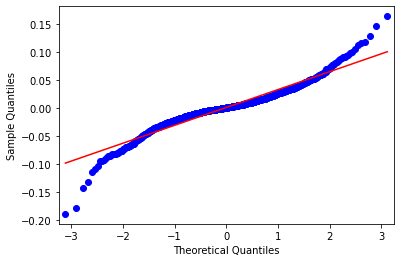

In [123]:
qqplot(btc_altcoin_OLS_pc['WeightedPrice'], line='s')
plt.show()

In [124]:
X_train, X_test, y_train, y_test = train_test_split(btc_altcoin_OLS_pc['Cost_per_TR'],
                                                    btc_altcoin_OLS_pc['WeightedPrice'],
                                                    test_size=0.2, random_state=12)

In [125]:
X = btc_altcoin_OLS['Cost_per_TR']
X = sm.add_constant(X)
Y = btc_altcoin_OLS['WeightedPrice']

In [126]:
model = sm.OLS(Y, X).fit()
predictions = model.predict(X)

In [127]:
print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:          WeightedPrice   R-squared:                       0.217
Model:                            OLS   Adj. R-squared:                  0.216
Method:                 Least Squares   F-statistic:                     303.3
Date:                Wed, 14 Apr 2021   Prob (F-statistic):           3.87e-60
Time:                        23:41:08   Log-Likelihood:                -10409.
No. Observations:                1096   AIC:                         2.082e+04
Df Residuals:                    1094   BIC:                         2.083e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const        4796.1931    243.005     19.737      

#### Interpretation

<ul>
    <li>Adj R-square: good model fit</li>
    <li>Constant: Independent Average price of BTC over 7 Years</li>
    <li>Std error: high level of accuracy</li>
    <li>p-value: Model is statistically significant</li>
    <li>Durbin-Watson test: a positive autocorrelation is present, eg a EMA of the Altcoins yesterday is indicating a greater likelihood in BTC price increase in the future</li>
    
    
</ul>

#### Testing the price difference between exchanges

In [128]:
df_btc_data.tail()

,Open,High,Low,Close,Volume_BTC,Volume_USD,Weighted Price,Exchange,Market
2021-04-13,59847.888448,63696.013872,59813.000000,63562.975202,1753.887293,1.087544e+08,62007.654271,POLONIEX,BTC
2021-04-13,59823.700000,63882.500000,59781.200000,63273.900000,6033.352095,3.762001e+08,62353.412081,KRAKEN,BTC
2021-04-13,59814.870000,63769.000000,59780.000000,63315.590000,5617.564271,3.489718e+08,62121.551005,BITSTAMP,BTC
2021-04-13,59860.800000,63647.200000,59855.700000,63228.800000,196.629918,1.225174e+07,62308.619925,CEX,BTC
2021-04-14,63573.512081,64970.000000,61347.842075,61705.594089,1493.201851,9.490505e+07,63558.081850,POLONIEX,BTC


In [129]:
df_btc_test = df_btc_data[['Weighted Price', 'Exchange']].reset_index().rename(columns={'index':'Date'})
df_btc_test.set_index('Date', inplace=True)
df_btc_test = df_btc_test.pivot_table('Weighted Price', ['Date'], 'Exchange')
df_btc_test_cut = df_btc_test[df_btc_test.index>='2018-03-01']
df_btc_test_cut.dropna(axis=1, how='all', inplace=True)
df_btc_test_cut.replace(0, np.nan, inplace=True)

In [130]:
df_btc_test_cut.isna().sum()

Exchange
BITFLYER    505
BITSTAMP     10
CEX          10
ITBIT       816
KRAKEN       11
OKCOIN      569
P2PB2B      976
POLONIEX      0
dtype: int64

In [132]:
df_btc_test_fin = df_btc_test_cut.fillna(method='ffill')

In [133]:
df_btc_test_fin.isna().sum()

Exchange
BITFLYER     97
BITSTAMP      0
CEX           0
ITBIT         0
KRAKEN        0
OKCOIN        0
P2PB2B      329
POLONIEX      0
dtype: int64

In [134]:
df_btc_melt = pd.melt(df_btc_test_fin, value_vars=['BITSTAMP', 'CEX', 'KRAKEN', 'POLONIEX'], ignore_index=False)
df_btc_melt.columns = ['Exchanges', 'BTC_Price']

In [135]:
df_btc_melt_2018_2020 = df_btc_melt[df_btc_melt.index<='2020-10-30']

In [136]:
df_btc_melt_2018_2020.describe()

,BTC_Price
count,3900.000000
mean,7836.759689
std,2351.211840
min,3168.525629
25%,6405.844490
50%,7984.080923
75%,9534.302649
max,13487.384443


<AxesSubplot:xlabel='Date'>

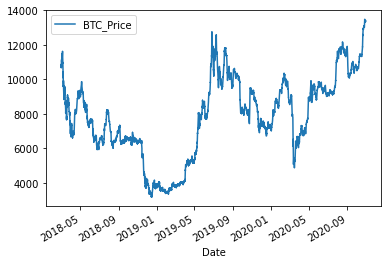

In [137]:
df_btc_melt_2018_2020.plot()

C:\Users\akosr\anaconda3\envs\project-crypto\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

10.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Users\akosr\anaconda3\envs\project-crypto\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

11.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Users\akosr\anaconda3\envs\project-crypto\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

10.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

C:\Users\akosr\anaconda3\envs\project-crypto\lib\site-packages\seaborn\categorical.py:1296: UserWarning:

10.1% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.



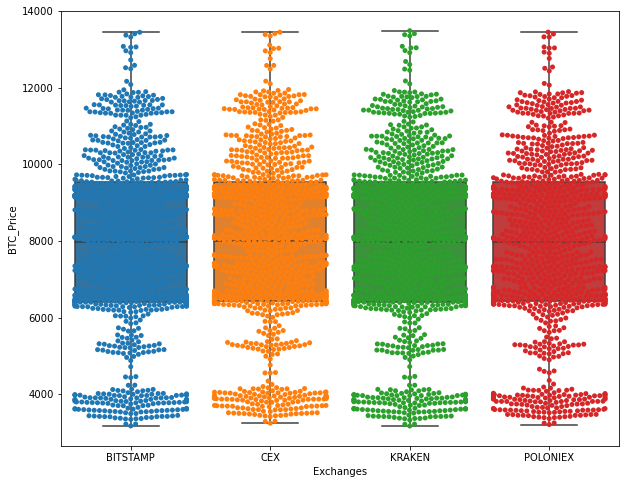

In [139]:
fig, ax = plt.subplots(figsize=(10,8))
_ax = sns.boxplot(x='Exchanges', y='BTC_Price', data=df_btc_melt_2018_2020)
_ax = sns.swarmplot(x='Exchanges', y='BTC_Price', data=df_btc_melt_2018_2020)
plt.show()

In [140]:
df_btc_melt_2018_2020['daily_pc_change'] = df_btc_melt_2018_2020['BTC_Price'].pct_change()

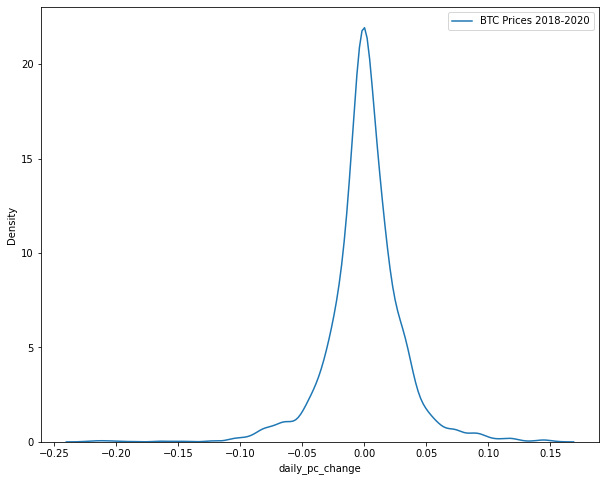

In [141]:
fig, ax = plt.subplots(figsize=(10,8))
_ax1 = sns.kdeplot(x='daily_pc_change', data=df_btc_melt_2018_2020)
plt.legend(['BTC Prices 2018-2020'])
plt.show()

### Multiple Linear Regression

In [144]:
features = btc_data_2018_2020[['Bu_Be_Spread_MA8', 'Num_TR_per_Block', 'GCF', 
               'DJI', 'XMR', 'LTC', 'ETC', 'DASH', 'XEM']]
price = btc_data_2018_2020['WeightedPrice']


X_train, X_test, y_train, y_test = train_test_split(features, price, test_size=0.3, random_state=42)
X_train.shape, X_test.shape

((767, 9), (329, 9))

In [151]:
import xgboost as xgb
from sklearn.metrics import r2_score, mean_squared_error

def adjusted_r2_score(y_true, y_pred, X_test):
    r2 = r2_score(y_true=y_true, y_pred=y_pred)
    adjusted_r2 = 1 - (1-r2)*(len(y_true)-1)/(len(y_true) - X_test.shape[1]-1)
    return adjusted_r2


xgr = xgb.XGBRegressor(objective='reg:linear', n_estimators=50, max_depth=5, n_jobs=-1, random_state=42)
xgr.fit(X_train, y_train)

y_pred = xgr.predict(X_test)

rsq_baseline_xgb = r2_score(y_true=y_test, y_pred=y_pred)
adj_rsq_baseline_xgb = adjusted_r2_score(y_true=y_test, y_pred=y_pred, X_test=X_test)
rmse_baseline_xgb = mean_squared_error(y_true=y_test, y_pred=y_pred) ** 0.5
print('R-sq:', rsq_baseline_xgb)
print('Adj. R-sq:', adj_rsq_baseline_xgb)
print('RMSE:', rmse_baseline_xgb)

[23:52:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/objective/regression_obj.cu:171: reg:linear is now deprecated in favor of reg:squarederror.
R-sq: 0.9914739650213326
Adj. R-sq: 0.9912334185799282
RMSE: 332.0131524964405


C:\Users\akosr\anaconda3\envs\project-crypto\lib\site-packages\xgboost\data.py:112: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

